# Phase 0: Setup

## Step 1: Import Libraries

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import chi2_contingency
from scipy import stats
import statsmodels.api as sm
import itertools 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # You used this
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.inspection import permutation_importance

## Step 2: Load Training Data

In [83]:
try:
    test = pd.read_csv('test.csv')
    train = pd.read_csv('train.csv')
    print('Successfully loaded .csv files')
except:
    print('Unable to find .csv files')

Successfully loaded .csv files


# Phase 1: Exploratory & Statistical Testing

## Early Visualizations
Shape of the data, cleaning the data, monovariate charts

### Shape of the data

In [84]:
# Describe tables
print(train.head())
print(train.info())
print(train.describe(include='all'))

   ID  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0         0         0         0         0         0   
4   5         0         0         0         0         0         0         0   

   A8_Score  A9_Score  ...  gender       ethnicity jaundice austim  \
0         0         1  ...       f               ?       no     no   
1         0         0  ...       m               ?       no     no   
2         1         1  ...       m  White-European       no    yes   
3         0         0  ...       f               ?       no     no   
4         0         0  ...       m               ?       no     no   

   contry_of_res used_app_before     result     age_desc  relation Class/ASD  
0        Austria         

### Cleaning the Data

**Reasoning**:
Handle the '?' values in the 'relation' column, remove the 'age_desc' and 'ID' columns, and check for remaining missing values as instructed.

In [85]:
# Justification:  The most frequent value is a simple and effective way to handle missing data in this case.  More sophisticated imputation might be considered if there were more clear relationships with other features.
train['relation'].replace('?', None, inplace=True)

# Remove the 'age_desc' column.
train.drop('age_desc', axis=1, inplace=True)

# Remove the 'id' column
train.drop('ID', axis=1, inplace=True)

# Check for remaining missing values.
print("\nMissing Values after cleaning:\n", train.isnull().sum())

# Verify the cleaning steps.
display(train.head())
print(train.shape)


Missing Values after cleaning:
 A1_Score            0
A2_Score            0
A3_Score            0
A4_Score            0
A5_Score            0
A6_Score            0
A7_Score            0
A8_Score            0
A9_Score            0
A10_Score           0
age                 0
gender              0
ethnicity           0
jaundice            0
austim              0
contry_of_res       0
used_app_before     0
result              0
relation           40
Class/ASD           0
dtype: int64


C:\Users\33322\AppData\Local\Temp\ipykernel_25100\429250228.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['relation'].replace('?', None, inplace=True)


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38.172746,f,?,no,no,Austria,no,6.351166,Self,0
1,0,0,0,0,0,0,0,0,0,0,47.750517,m,?,no,no,India,no,2.255185,Self,0
2,1,1,1,1,1,1,1,1,1,1,7.380373,m,White-European,no,yes,United States,no,14.851484,Self,1
3,0,0,0,0,0,0,0,0,0,0,23.561927,f,?,no,no,United States,no,2.276617,Self,0
4,0,0,0,0,0,0,0,0,0,0,43.205790,m,?,no,no,South Africa,no,-4.777286,Self,0


(800, 20)


### Monovariate Visualizations

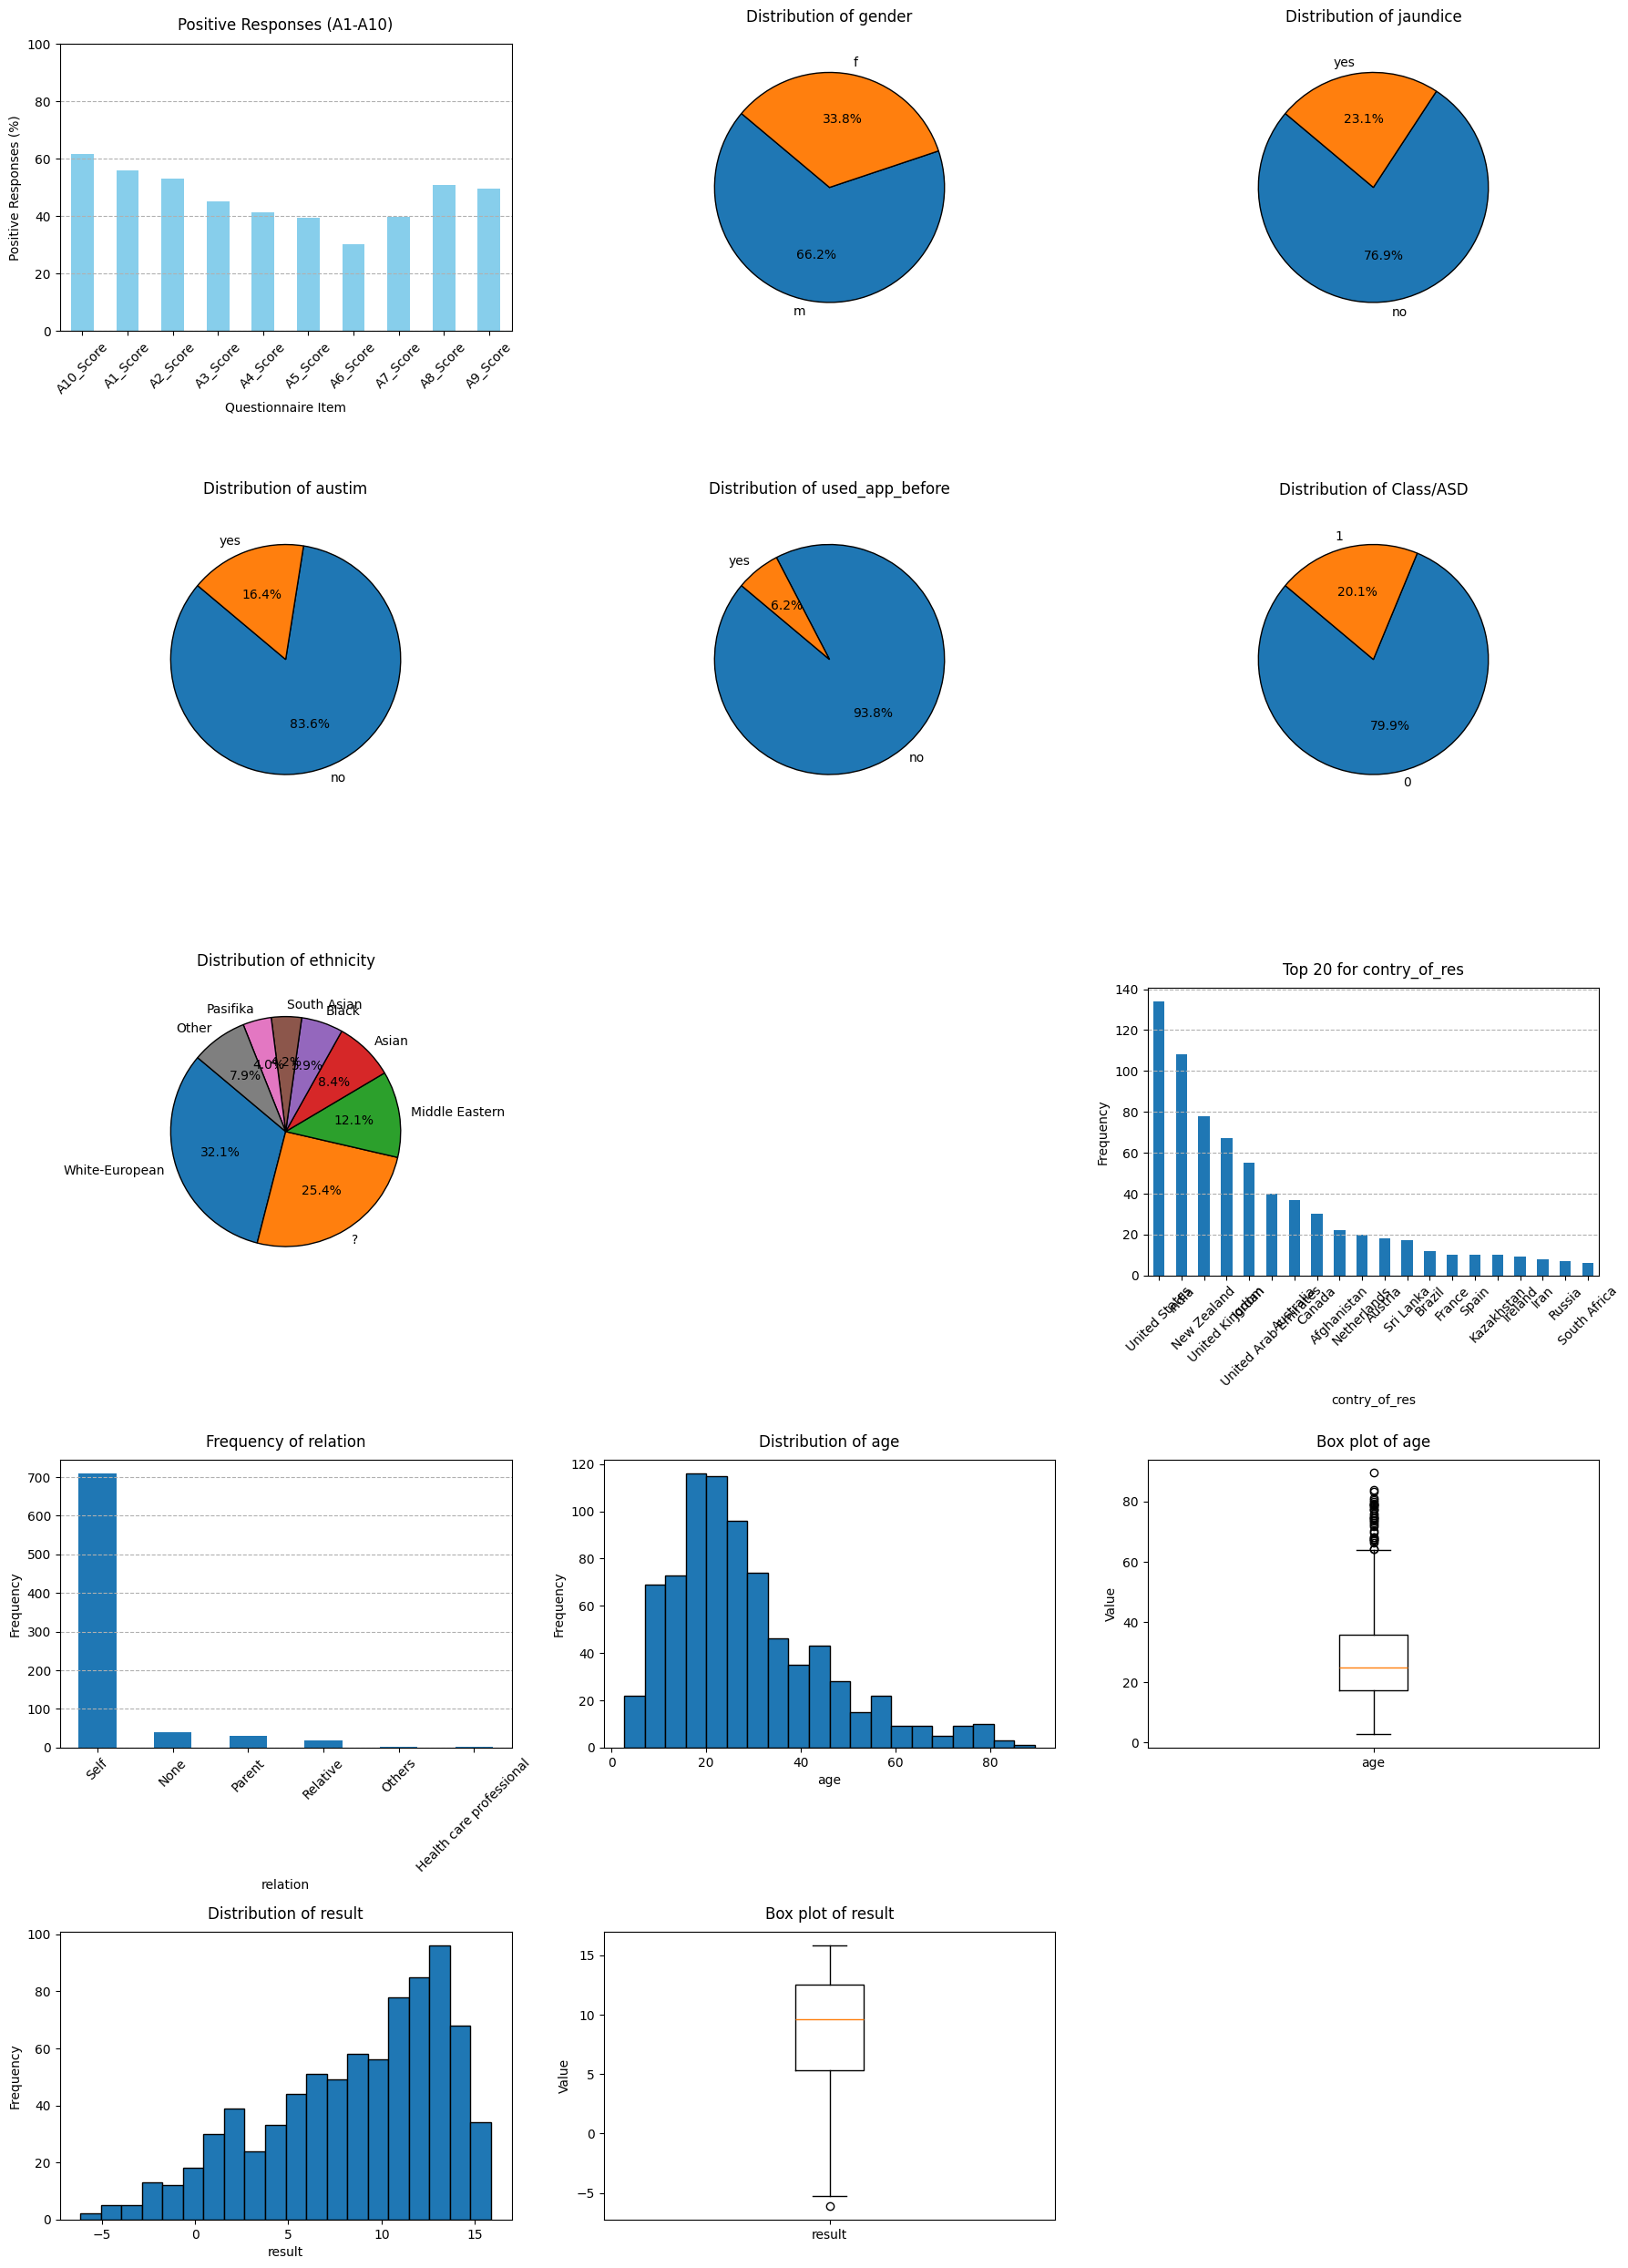

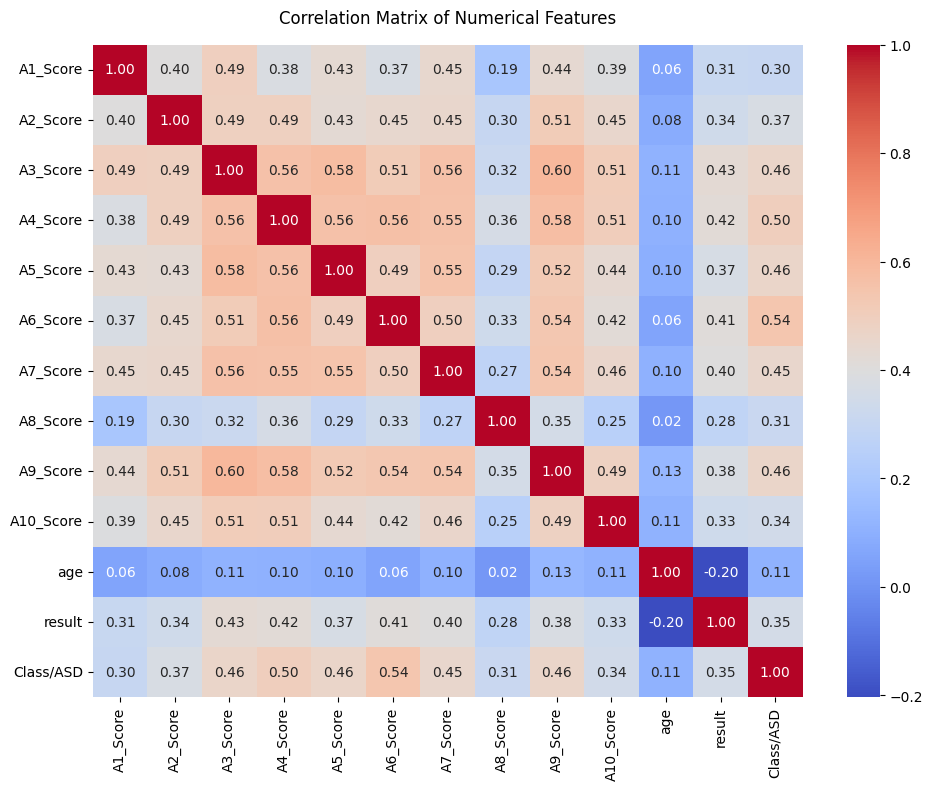

In [94]:
# 4.1
# --- Plotting Functions ---

def plot_positive_frequency_scores(ax, df, score_columns):
    positive_percentages = {}
    for col in score_columns:
        if col in df.columns:
            if df[col].dropna().isin([0, 1]).all():
                positive_percentages[col] = df[col].mean() * 100
    if not positive_percentages:
        ax.set_visible(False)
        return
    percentages_series = pd.Series(positive_percentages).sort_index()
    percentages_series.plot(kind='bar', color='skyblue', ax=ax)
    ax.set_title('Positive Responses (A1-A10)', y=1.02)
    ax.set_xlabel('Questionnaire Item')
    ax.set_ylabel('Positive Responses (%)')
    ax.set_ylim(0, 100)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--')

def plot_categorical_bar(ax, df, column_name, top_n=15):
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    counts = df[column_name].value_counts(dropna=False)
    if len(counts) > top_n:
        counts = counts.nlargest(top_n)
        title = f'Top {top_n} for {column_name}'
    else:
        title = f'Frequency of {column_name}'
    counts.plot(kind='bar', ax=ax)
    ax.set_title(title, y=1.02)
    ax.set_xlabel(column_name)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--')

def plot_continuous_hist(ax, df, column_name, bins=20):
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    df[column_name].plot(kind='hist', bins=bins, edgecolor='black', ax=ax)
    ax.set_title(f'Distribution of {column_name}', y=1.02)
    ax.set_xlabel(column_name)
    ax.set_ylabel('Frequency')

def plot_continuous_boxplot(ax, df, column_name):
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    ax.boxplot(df[column_name].dropna())
    ax.set_title(f'Box plot of {column_name}', y=1.02)
    ax.set_ylabel('Value')
    ax.set_xticks([1])
    ax.set_xticklabels([column_name])

def plot_pie_chart(ax, df, column_name, top_n_pie=10):
    if column_name not in df.columns:
        ax.set_visible(False)
        return
    counts = df[column_name].value_counts(dropna=False)
    nan_keys = [key for key in counts.index if pd.isna(key)]
    if nan_keys:
        counts = counts.rename(index={nan_keys[0]: 'NaN'})
    if len(counts) > top_n_pie:
        num_top = max(1, top_n_pie - 1)
        counts_top = counts.nlargest(num_top)
        other_sum = counts[~counts.index.isin(counts_top.index)].sum()
        final_counts = counts_top.copy()
        if other_sum > 0:
            final_counts['Other'] = other_sum
        counts = final_counts
    labels = [str(label) for label in counts.index]
    sizes = counts.values
    if sizes.sum() == 0:
        ax.set_visible(False)
        return
    ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        wedgeprops={'edgecolor': 'black'}
    )
    ax.set_title(f'Distribution of {column_name}', y=1.05)

def plot_correlation_heatmap(df, figsize=(10, 8)):
    numerical_features = df.select_dtypes(include=['number'])
    correlation_matrix = numerical_features.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features', y=1.02)
    plt.tight_layout()
    plt.show()

# --- Grid Plotting Utility ---

def plot_in_grid(plot_funcs, ncols=3, figsize=(18, 5)):
    n_plots = len(plot_funcs)
    nrows = int(np.ceil(n_plots / ncols))
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(figsize[0], figsize[1]*nrows)
    )
    axes = axes.flatten()
    for i, (plot_func, args, kwargs) in enumerate(plot_funcs):
        plot_func(axes[i], *args, **kwargs)
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

# --- Build Plotting Tasks ---

binary_score_columns = [f'A{i}_Score' for i in range(1, 11)]
pie_columns = [
    'gender', 'jaundice', 'austim', 'used_app_before',
    'Class/ASD', 'ethnicity', 'age_desc'
]
bar_columns = ['contry_of_res', 'relation']
continuous_columns = ['age', 'result']

plot_funcs = []

# 1. Positive frequency bar (A1-A10)
plot_funcs.append(
    (plot_positive_frequency_scores, (train, binary_score_columns), {})
)

# 2. Pie charts
for col in pie_columns:
    if col == 'ethnicity':
        plot_funcs.append(
            (plot_pie_chart, (train, col), {'top_n_pie': 8})
        )
    elif col == 'age_desc':
        plot_funcs.append(
            (plot_pie_chart, (train, col), {'top_n_pie': 7})
        )
    else:
        plot_funcs.append(
            (plot_pie_chart, (train, col), {})
        )

# 3. Bar charts
for col in bar_columns:
    if col == 'contry_of_res':
        plot_funcs.append(
            (plot_categorical_bar, (train, col), {'top_n': 20})
        )
    else:
        plot_funcs.append(
            (plot_categorical_bar, (train, col), {})
        )

# 4. Continuous histograms and boxplots
for col in continuous_columns:
    plot_funcs.append(
        (plot_continuous_hist, (train, col), {})
    )
    plot_funcs.append(
        (plot_continuous_boxplot, (train, col), {})
    )

# --- Plot All in a Grid ---

plot_in_grid(plot_funcs, ncols=3, figsize=(18, 5))

# --- Correlation Heatmap (separate plot) ---

plot_correlation_heatmap(train)

Starting visualizations...

Visualizing positive frequency for A1-A10 Score columns...


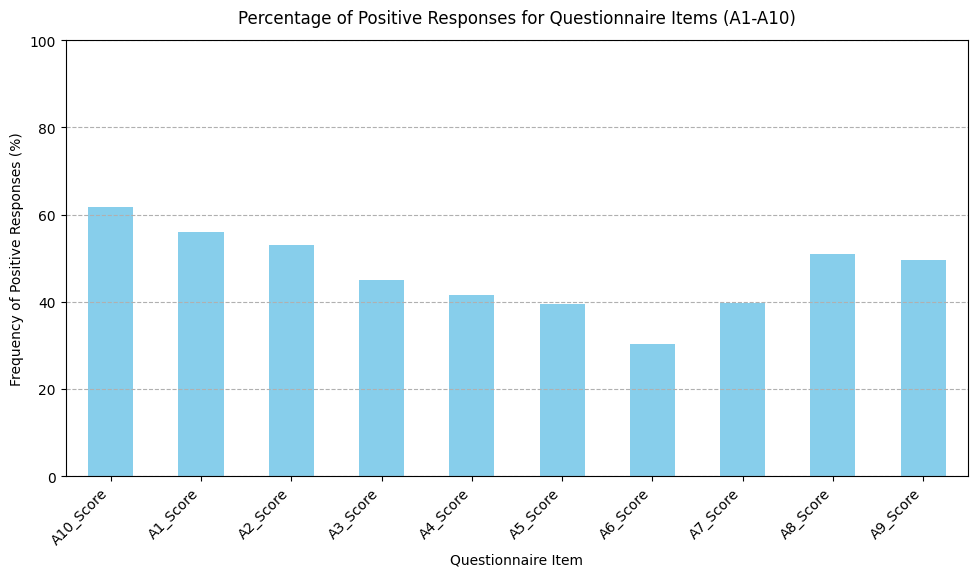


Visualizing categorical column as Pie Chart: gender


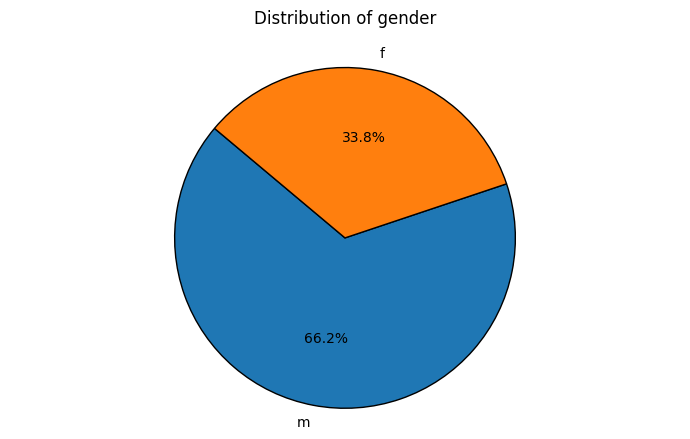


Visualizing categorical column as Pie Chart: jaundice


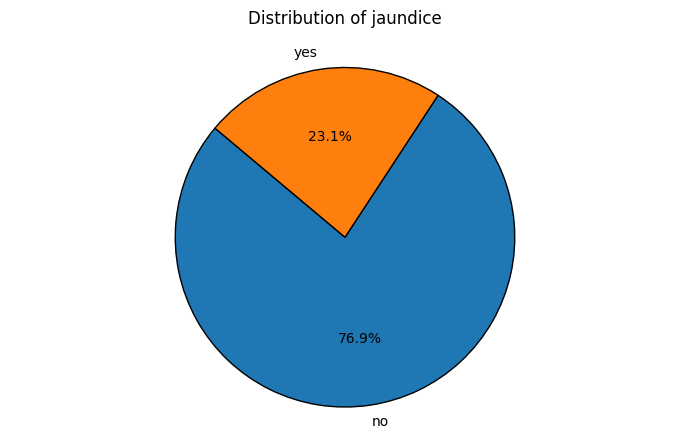


Visualizing categorical column as Pie Chart: austim


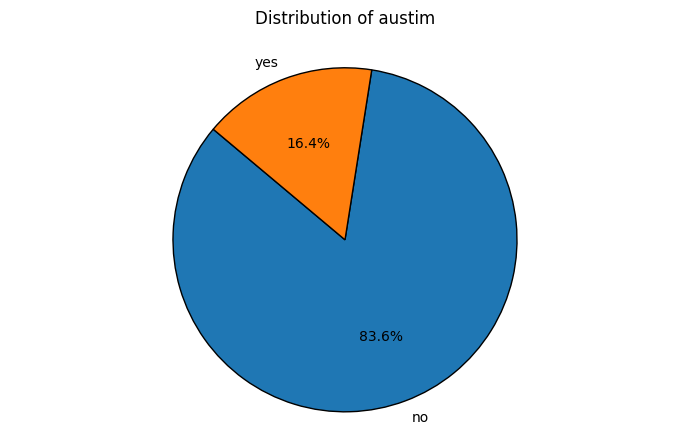


Visualizing categorical column as Pie Chart: used_app_before


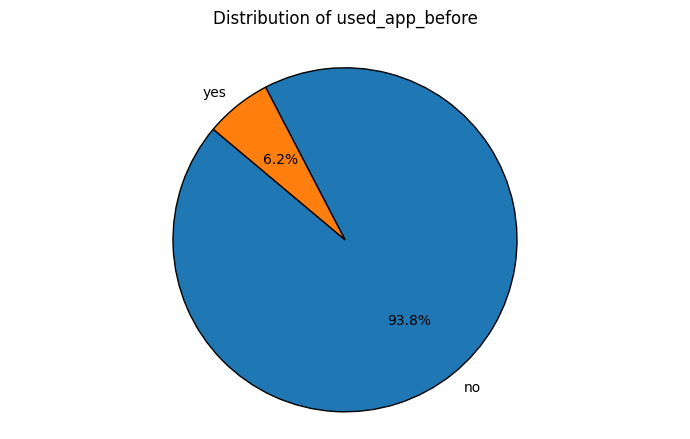


Visualizing categorical column as Pie Chart: Class/ASD


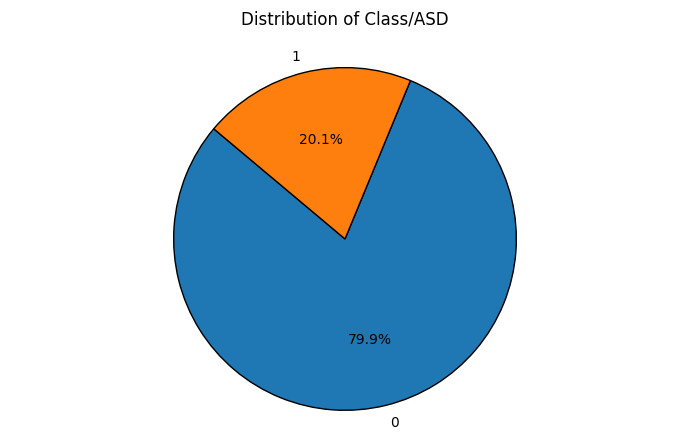


Visualizing categorical column as Pie Chart: ethnicity
Column 'ethnicity' has 12 unique values. Displaying top 7 categories and 'Other'.


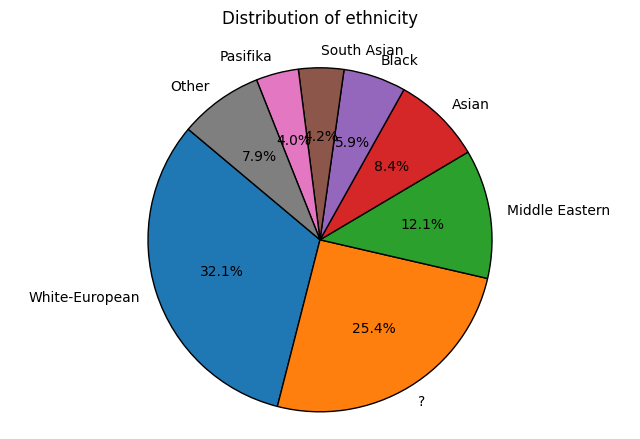


Visualizing categorical column as Bar Chart: contry_of_res


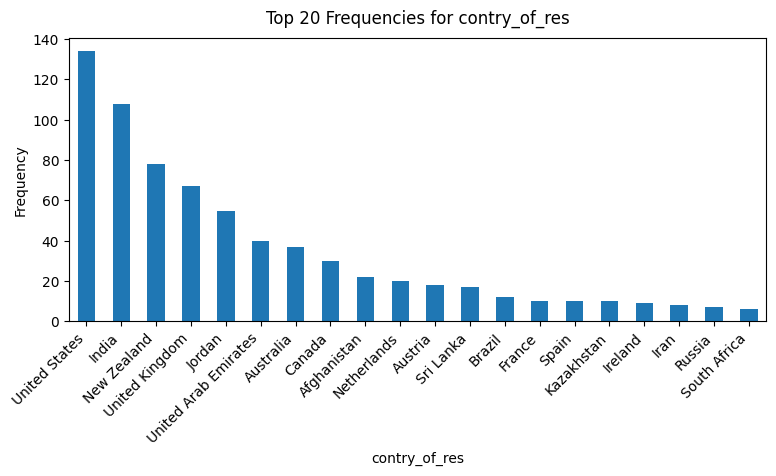


Visualizing categorical column as Bar Chart: relation
Note: Column 'relation' contains NaN values. Displaying them as 'NaN' in the plot.


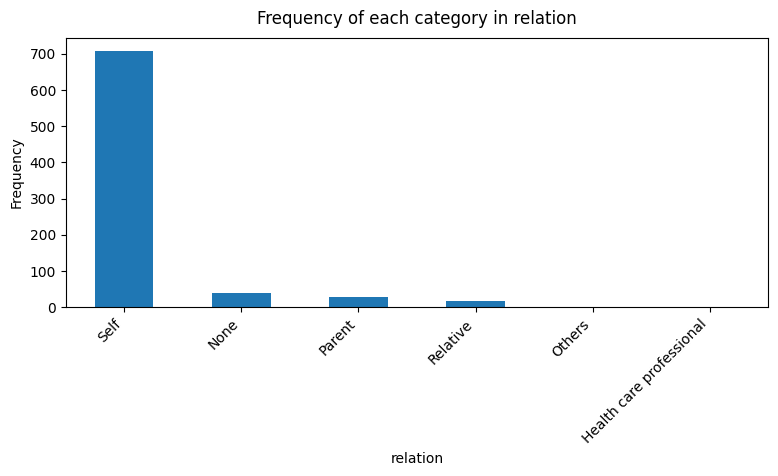


Visualizing continuous column (histogram): age


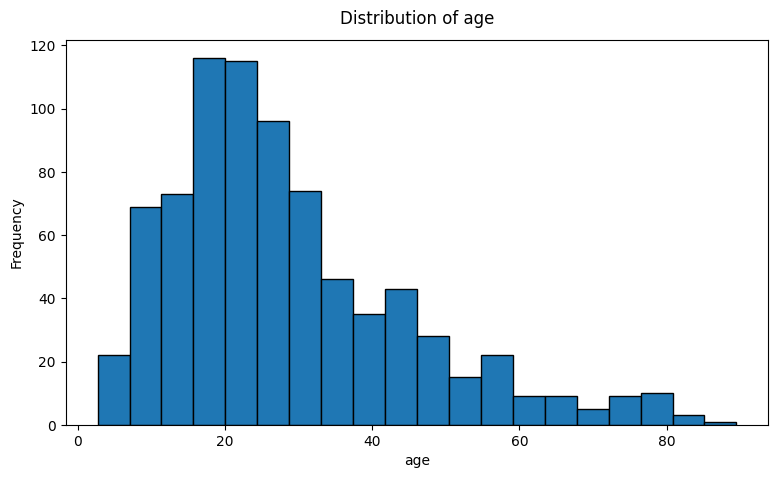


Visualizing continuous column (boxplot): age


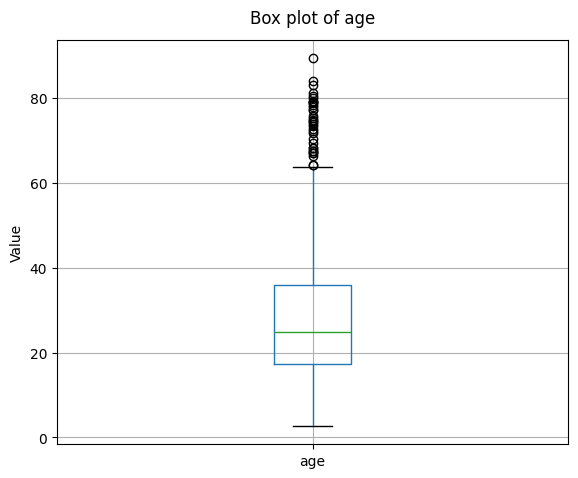


Visualizing continuous column (histogram): result


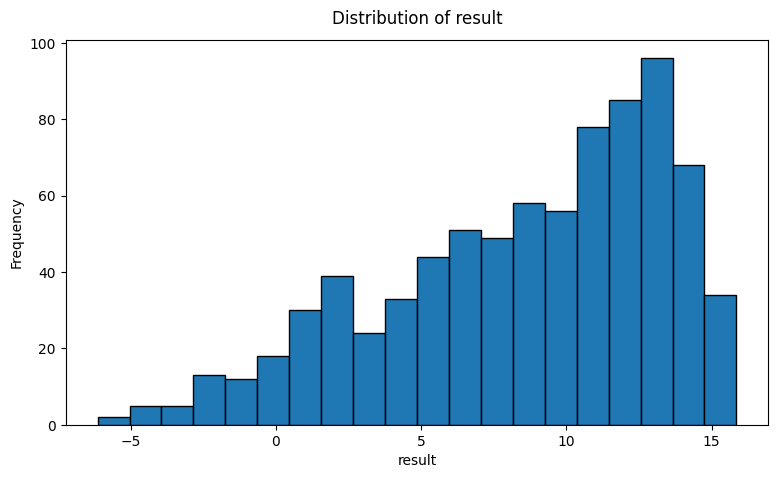


Visualizing continuous column (boxplot): result


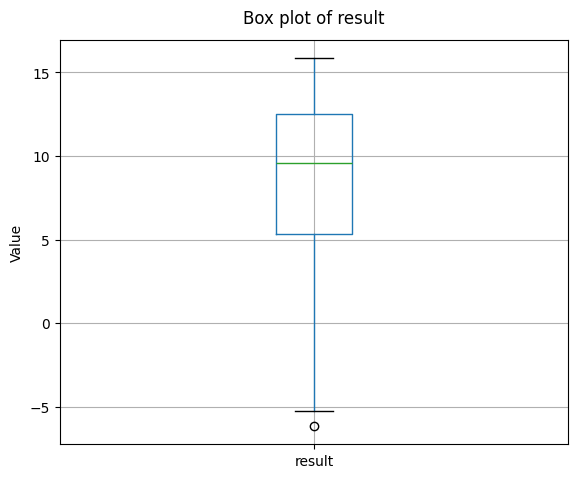


All requested visualizations have been generated (or attempted).


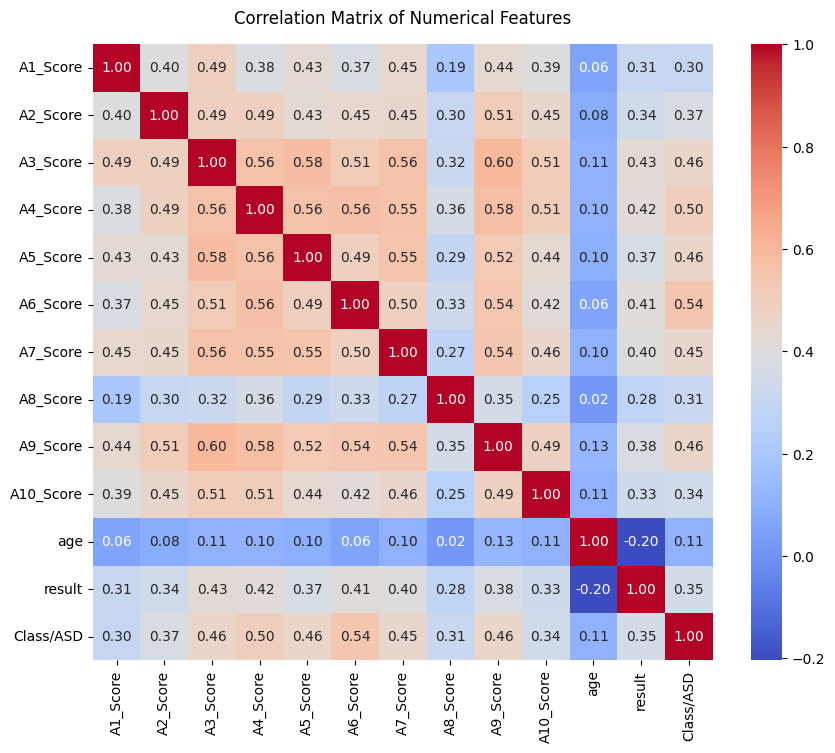

In [86]:
#@title Plotting Data
def plot_positive_frequency_scores(df, score_columns):
    """
    Generates a singular bar chart showing the percentage of positive responses (1s)
    for the specified score columns.
    """
    positive_percentages = {}
    for col in score_columns:
        if col in df.columns:
            if train[col].dropna().isin([0, 1]).all(): # Check if column is binary (0 or 1) after dropping NaNs
                # Calculate percentage of 1s.
                # df[col].mean() directly gives the proportion of 1s for binary 0/1 data.
                positive_percentages[col] = df[col].mean() * 100
            else:
                print(f"Warning: Column {col} is not strictly binary (0 or 1) or contains NaNs not handled by mean. Skipping for positive frequency plot.")
        else:
            print(f"Warning: Column {col} not found in DataFrame.")

    if not positive_percentages:
        print("No valid score columns found or no data to plot for positive frequencies.")
        return

    # Create a pandas Series for easy plotting
    percentages_series = pd.Series(positive_percentages)
    percentages_series = percentages_series.sort_index() # Sort by question number for A1, A2... order

    # MODIFIED: Reduced figure size from (12, 7) to (10, 6)
    plt.figure(figsize=(10, 6))
    percentages_series.plot(kind='bar', color='skyblue')
    # MODIFIED: Added y parameter to title
    plt.title('Percentage of Positive Responses for Questionnaire Items (A1-A10)', y=1.02)
    plt.xlabel('Questionnaire Item')
    plt.ylabel('Frequency of Positive Responses (%)')
    plt.ylim(0, 100) # Set y-axis from 0% to 100%
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    # MODIFIED: Added pad parameter to tight_layout
    plt.tight_layout(pad=1.5)
    plt.show()

def plot_categorical_bar(df, column_name, top_n=15):
    """
    Generates a bar plot for a categorical or binary column.
    For columns with many unique values, it plots the top_n most frequent ones.
    """
    # MODIFIED: Reduced figure size from (10, 6) to (8, 5)
    plt.figure(figsize=(8, 5))
    # Check if the column contains NaN values and how to handle them
    if df[column_name].isnull().any():
        counts = df[column_name].value_counts(dropna=False) # Include NaNs in counts
        print(f"Note: Column '{column_name}' contains NaN values. Displaying them as 'NaN' in the plot.")
    else:
        counts = df[column_name].value_counts()

    if len(counts) > top_n:
        # Plot top N categories for readability
        counts = counts.nlargest(top_n)
        counts.plot(kind='bar')
        # MODIFIED: Added y parameter to title
        plt.title(f'Top {top_n} Frequencies for {column_name}', y=1.02)
    else:
        counts.plot(kind='bar')
        # MODIFIED: Added y parameter to title
        plt.title(f'Frequency of each category in {column_name}', y=1.02)
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    # MODIFIED: Added pad parameter to tight_layout
    plt.tight_layout(pad=1.5)
    plt.show()

def plot_continuous_hist(df, column_name, bins=20):
    """
    Generates a histogram for a continuous numerical column.
    """
    # MODIFIED: Reduced figure size from (10, 6) to (8, 5)
    plt.figure(figsize=(8, 5))
    df[column_name].plot(kind='hist', bins=bins, edgecolor='black') # Added edgecolor for better bar distinction
    # MODIFIED: Added y parameter to title
    plt.title(f'Distribution of {column_name}', y=1.02)
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    # MODIFIED: Added pad parameter to tight_layout
    plt.tight_layout(pad=1.5)
    plt.show()

def plot_continuous_boxplot(df, column_name):
    """
    Generates a box plot for a continuous numerical column.
    """
    # MODIFIED: Reduced figure size from (8, 6) to (6, 5)
    plt.figure(figsize=(6, 5))
    df.boxplot(column=[column_name])
    # MODIFIED: Added y parameter to title
    plt.title(f'Box plot of {column_name}', y=1.02)
    plt.ylabel('Value')
    # MODIFIED: Added pad parameter to tight_layout
    plt.tight_layout(pad=1.5)
    plt.show()

def plot_pie_chart(df, column_name, top_n_pie=10):
    """
    Generates a pie chart for a categorical column, showing percentages.
    If the number of unique categories exceeds top_n_pie, it groups the smallest
    categories into an 'Other' slice.
    Includes NaNs as a separate category if present.
    """
    # MODIFIED: Reduced figure size from (10, 8) to (7, 5)
    plt.figure(figsize=(7, 5)) # Adjusted size for pie charts

    # Calculate value counts, including NaNs. Rename NaN index to string 'NaN' for display.
    # temp_series = df[column_name].fillna('NaN_placeholder') # Fill NaNs for value_counts
    # counts = temp_series.value_counts()
    # if 'NaN_placeholder' in counts.index:
    #     counts = counts.rename(index={'NaN_placeholder': 'NaN'})
    # Using dropna=False and then renaming is cleaner if NaN is a standard float NaN
    if df[column_name].isnull().any():
        counts = df[column_name].value_counts(dropna=False)
        # Check if float('nan') is in index (common for numeric columns with NaNs)
        # or if None is in index (common for object columns with NaNs)
        nan_keys = [key for key in counts.index if pd.isna(key)]
        if nan_keys:
            # For simplicity, assuming one type of NaN representation in index
            # If multiple (e.g. None and np.nan), this might need adjustment
            counts = counts.rename(index={nan_keys[0]: 'NaN'})
        print(f"Note: Column '{column_name}' contains NaN values. Displaying them as 'NaN' in the pie chart.")
    else:
        counts = df[column_name].value_counts()


    if len(counts) == 0:
        print(f"No data to plot for column '{column_name}'.")
        plt.close() # Close the figure if nothing to plot
        return

    labels_to_plot = counts.index
    sizes_to_plot = counts.values

    if len(counts) > top_n_pie:
        print(f"Column '{column_name}' has {len(counts)} unique values. Displaying top {top_n_pie-1} categories and 'Other'.")
        # Ensure top_n_pie-1 is at least 1 for sensible plotting of top categories + Other
        num_top_categories = max(1, top_n_pie - 1)
        counts_top = counts.nlargest(num_top_categories)

        # Sum of all categories not in counts_top
        # This correctly handles cases where len(counts) is just slightly more than num_top_categories
        if len(counts_top) < len(counts): # Ensure there are actually 'other' categories
            other_sum = counts[~counts.index.isin(counts_top.index)].sum()
        else:
            other_sum = 0

        final_counts = counts_top.copy() # Use .copy()
        if other_sum > 0: # Add 'Other' slice only if there are values to group
            final_counts['Other'] = other_sum

        labels_to_plot = final_counts.index
        sizes_to_plot = final_counts.values

    # Ensure all labels are strings for matplotlib
    labels_to_plot = [str(label) for label in labels_to_plot]

    # Filter out zero-sized slices to prevent matplotlib warnings/errors if any 'Other' sum became 0
    # or if original counts had zeros that weren't filtered by value_counts.
    non_zero_indices = [i for i, size in enumerate(sizes_to_plot) if size > 0]
    labels_to_plot = [labels_to_plot[i] for i in non_zero_indices]
    sizes_to_plot = [sizes_to_plot[i] for i in non_zero_indices]

    if not sizes_to_plot: # If all slices ended up being zero
        print(f"No non-zero data to plot for column '{column_name}' after processing.")
        plt.close()
        return

    plt.pie(sizes_to_plot, labels=labels_to_plot, autopct='%1.1f%%', startangle=140,
            wedgeprops={'edgecolor': 'black'}) # Added edgecolor for slice distinction
    # MODIFIED: Added y parameter to title
    plt.title(f'Distribution of {column_name}', y=1.05)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    # MODIFIED: Added rect parameter to tight_layout
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


def visualize_all_variables(df):
    """
    Visualizes all relevant variables in the DataFrame by calling
    appropriate plotting functions based on column names and data types.
    """
    print("Starting visualizations...")

    # Identify columns based on their nature
    binary_score_columns = [f'A{i}_Score' for i in range(1, 11)]

    # Columns requested for pie charts
    columns_to_plot_as_pie = ['gender', 'jaundice', 'austim', 'used_app_before', 'Class/ASD', 'ethnicity', 'age_desc']

    # Define all known categorical columns that might be plotted to maintain a consistent iteration order
    # This list reflects the order from the original separate lists.
    all_categorical_columns_to_plot = [
        'gender', 'jaundice', 'austim', 'used_app_before', 'Class/ASD', # Previously other_binary_categorical_columns
        'ethnicity', 'contry_of_res', 'age_desc', 'relation'            # Previously multi_categorical_columns
    ]

    continuous_columns = ['age', 'result']
    id_column = 'ID' # To be skipped

    # Plot binary score columns (A1_Score to A10_Score) as a single percentage chart
    print("\nVisualizing positive frequency for A1-A10 Score columns...")
    if any(col in df.columns for col in binary_score_columns):
        plot_positive_frequency_scores(df, binary_score_columns)
    else:
        print("Warning: None of the A1-A10_Score columns found in DataFrame. Skipping positive frequency plot.")

    # Plot other categorical columns
    for col in all_categorical_columns_to_plot:
        if col in df.columns:
            if col in columns_to_plot_as_pie:
                print(f"\nVisualizing categorical column as Pie Chart: {col}")
                # Specific top_n_pie for columns that might have many categories
                if col == 'ethnicity':
                    plot_pie_chart(df, col, top_n_pie=8) # e.g., top 7 + Other
                elif col == 'age_desc':
                    plot_pie_chart(df, col, top_n_pie=7) # e.g., top 6 + Other
                else:
                    # For binary/few category columns like gender, jaundice, etc.
                    # Default top_n_pie is 10, which means all categories will be shown
                    # if they have less than 10 unique values.
                    plot_pie_chart(df, col)
            else: # These will be bar charts ('contry_of_res', 'relation')
                print(f"\nVisualizing categorical column as Bar Chart: {col}")
                # Apply original top_n logic for specific bar charts
                if col == 'contry_of_res':
                    plot_categorical_bar(df, col, top_n=20)
                else: # For 'relation' or any other not specified for pie or special bar
                      # This will use the default top_n=15 from plot_categorical_bar
                    plot_categorical_bar(df, col)
        else:
            print(f"Warning: Column {col} not found in DataFrame.")

    # Plot continuous columns
    for col in continuous_columns:
        if col in df.columns:
            print(f"\nVisualizing continuous column (histogram): {col}")
            plot_continuous_hist(df, col)
            print(f"\nVisualizing continuous column (boxplot): {col}")
            plot_continuous_boxplot(df, col)
        else:
            print(f"Warning: Column {col} not found in DataFrame.")

    if id_column in df.columns:
        print(f"\nSkipping visualization for ID column: {id_column}")

    print("\nAll requested visualizations have been generated (or attempted).")

visualize_all_variables(train)

# Correlation Heatmap (Numerical Features)
numerical_features = train.select_dtypes(include=['number'])
correlation_matrix = numerical_features.corr()
# MODIFIED: Reduced figure size from (12, 10) to (10, 8)
plt.figure(figsize=(10, 8))
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# MODIFIED: Added y parameter to title
plt.title('Correlation Matrix of Numerical Features', y=1.02)
plt.show()


## Phase 1.1: Cleaning the Data

## Data preparation

### Subtask:
Prepare the data for modeling by encoding categorical features, scaling numerical features, and separating predictor and target variables.


**Reasoning**:
Prepare the data for modeling by encoding categorical features, scaling numerical features, and separating predictor and target variables.



In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Identify categorical and numerical features
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('Class/ASD') # Remove target from numerical features

# Encode categorical features using one-hot encoding
df_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)

# Separate features (X) and target (y)
X = df_encoded.drop('Class/ASD', axis=1)
y = df_encoded['Class/ASD']

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

display(X.head())
print(X.shape)
display(y.head())
print(y.shape)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,contry_of_res_Ukraine,contry_of_res_United Arab Emirates,contry_of_res_United Kingdom,contry_of_res_United States,contry_of_res_Viet Nam,used_app_before_yes,relation_Others,relation_Parent,relation_Relative,relation_Self
0,0.886405,-1.061913,1.105542,-0.842260,1.237597,-0.660504,1.231147,-1.017656,1.010051,0.787041,...,False,False,False,False,False,False,False,False,False,True
1,-1.128152,-1.061913,-0.904534,-0.842260,-0.808018,-0.660504,-0.812251,-1.017656,-0.990050,-1.270582,...,False,False,False,False,False,False,False,False,False,True
2,0.886405,0.941697,1.105542,1.187282,1.237597,1.513995,1.231147,0.982650,1.010051,0.787041,...,False,False,False,True,False,False,False,False,False,True
3,-1.128152,-1.061913,-0.904534,-0.842260,-0.808018,-0.660504,-0.812251,-1.017656,-0.990050,-1.270582,...,False,False,False,True,False,False,False,False,False,True
4,-1.128152,-1.061913,-0.904534,-0.842260,-0.808018,-0.660504,-0.812251,-1.017656,-0.990050,-1.270582,...,False,False,False,False,False,False,False,False,False,True


(800, 86)


0    0
1    0
2    1
3    0
4    0
Name: Class/ASD, dtype: int64

(800,)



Chi-Square Test Results:

ethnicity vs Class/ASD:
Chi-square statistic: 181.02
p-value: 0.0000
Degrees of freedom: 11

contry_of_res vs relation:
Chi-square statistic: 549.32
p-value: 0.0000
Degrees of freedom: 216

austim vs Class/ASD:
Chi-square statistic: 100.82
p-value: 0.0000
Degrees of freedom: 1

contry_of_res vs Class/ASD:
Chi-square statistic: 205.75
p-value: 0.0000
Degrees of freedom: 55

ethnicity vs austim:
Chi-square statistic: 98.23
p-value: 0.0000
Degrees of freedom: 11

austim vs contry_of_res:
Chi-square statistic: 149.74
p-value: 0.0000
Degrees of freedom: 55

ethnicity vs jaundice:
Chi-square statistic: 37.17
p-value: 0.0001
Degrees of freedom: 11

jaundice vs Class/ASD:
Chi-square statistic: 14.60
p-value: 0.0001
Degrees of freedom: 1

jaundice vs austim:
Chi-square statistic: 8.96
p-value: 0.0028
Degrees of freedom: 1

contry_of_res vs used_app_before:
Chi-square statistic: 88.17
p-value: 0.0030
Degrees of freedom: 55

ethnicity vs relation:
Chi-square statistic: 

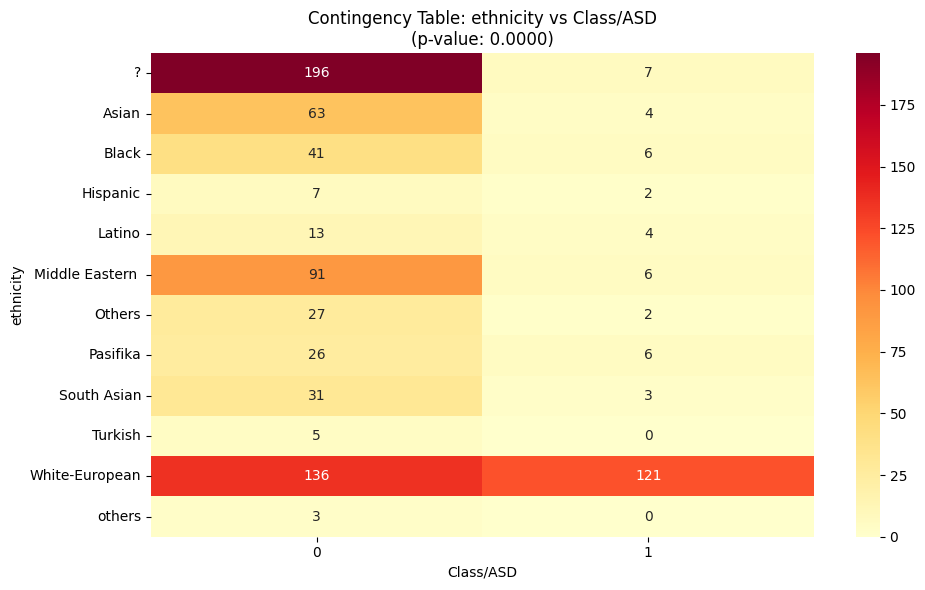

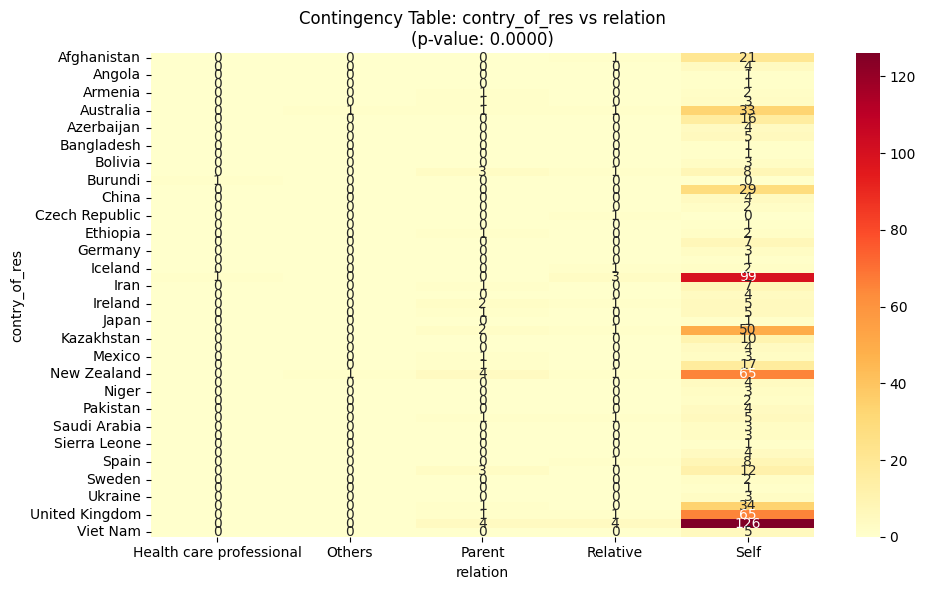

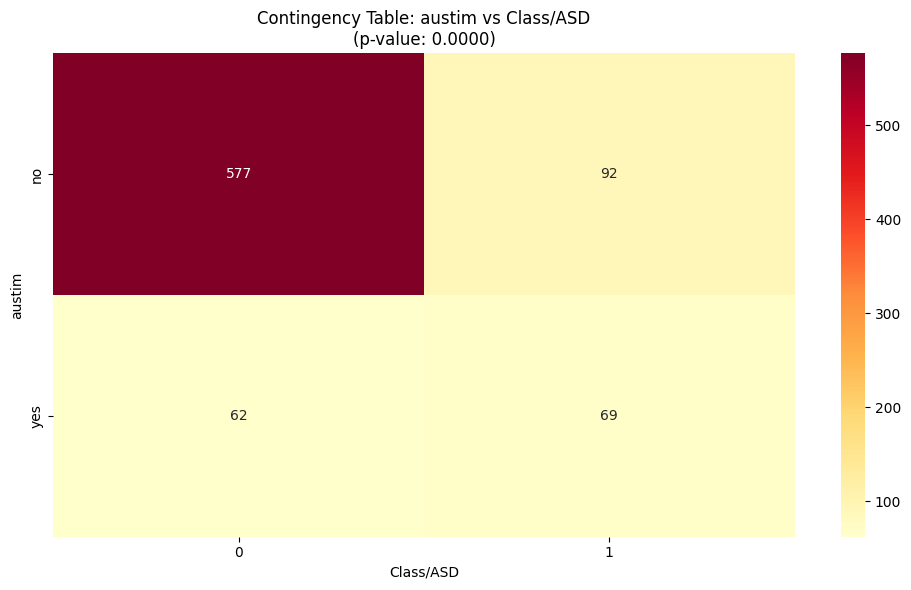

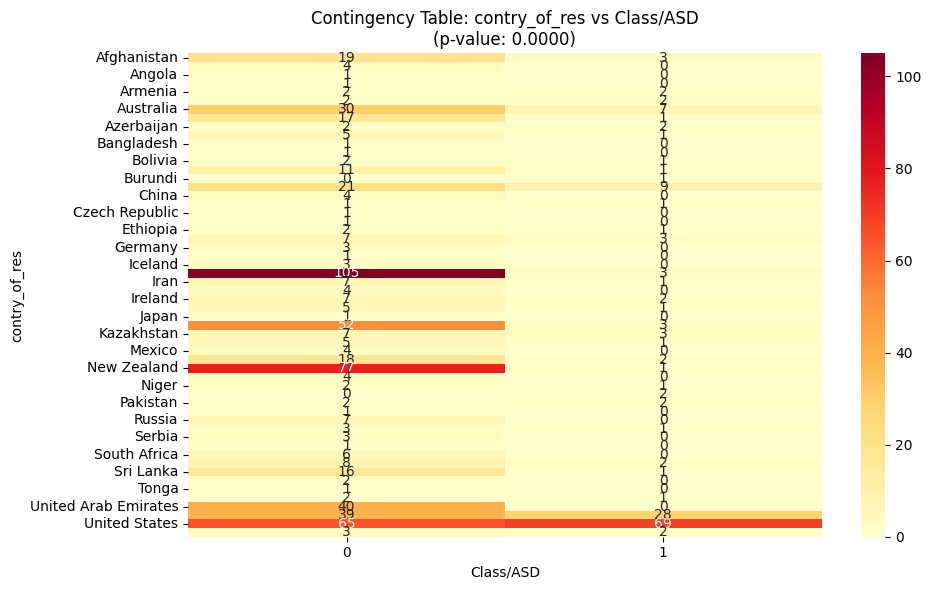

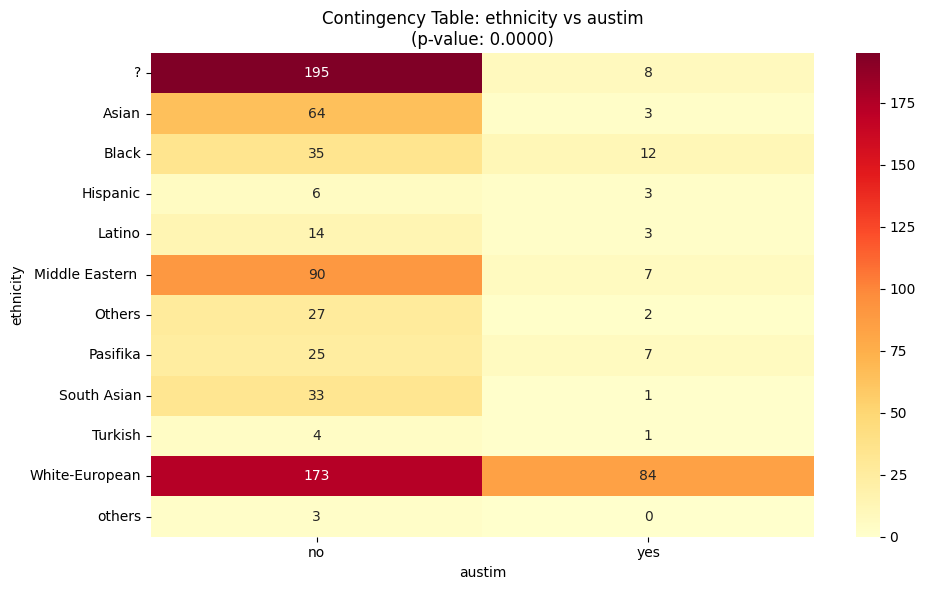

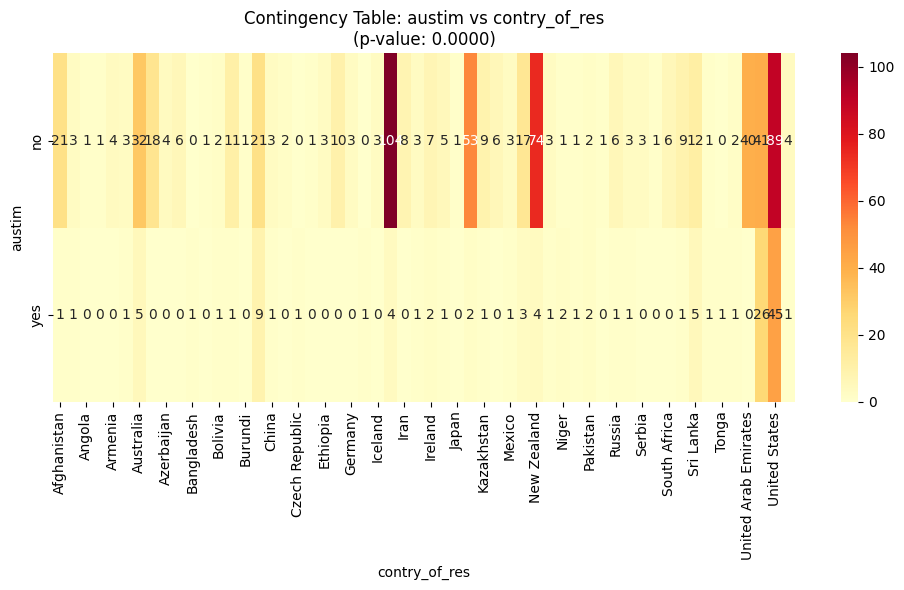

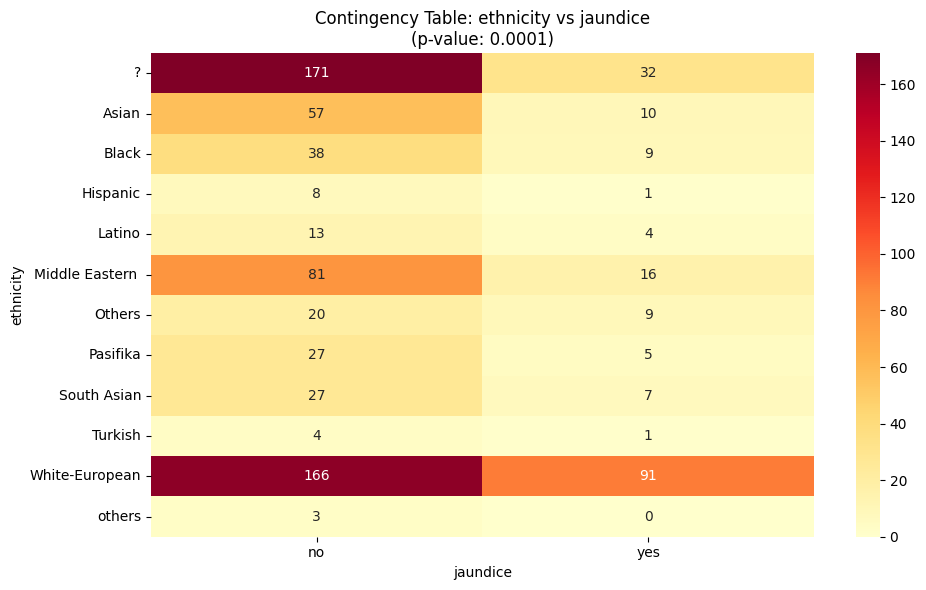

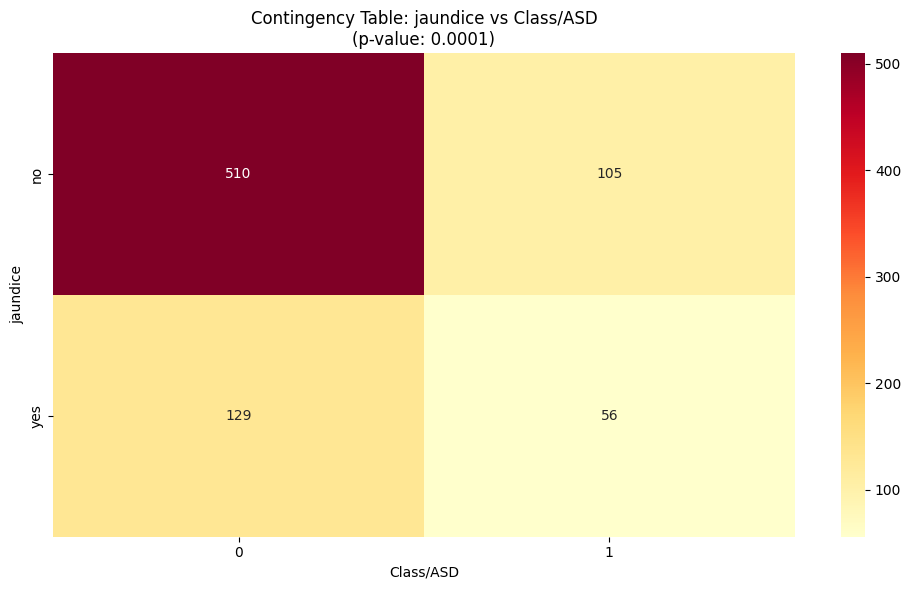

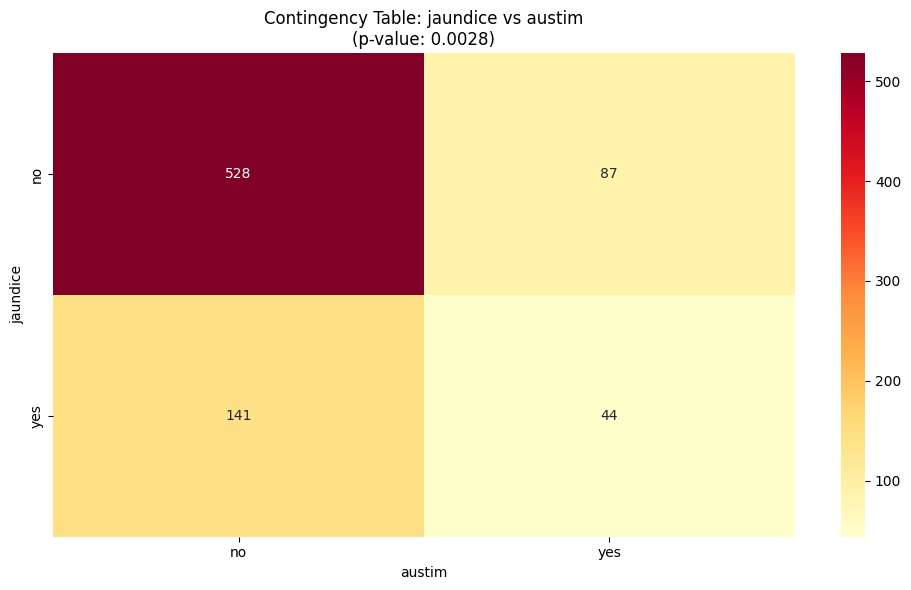

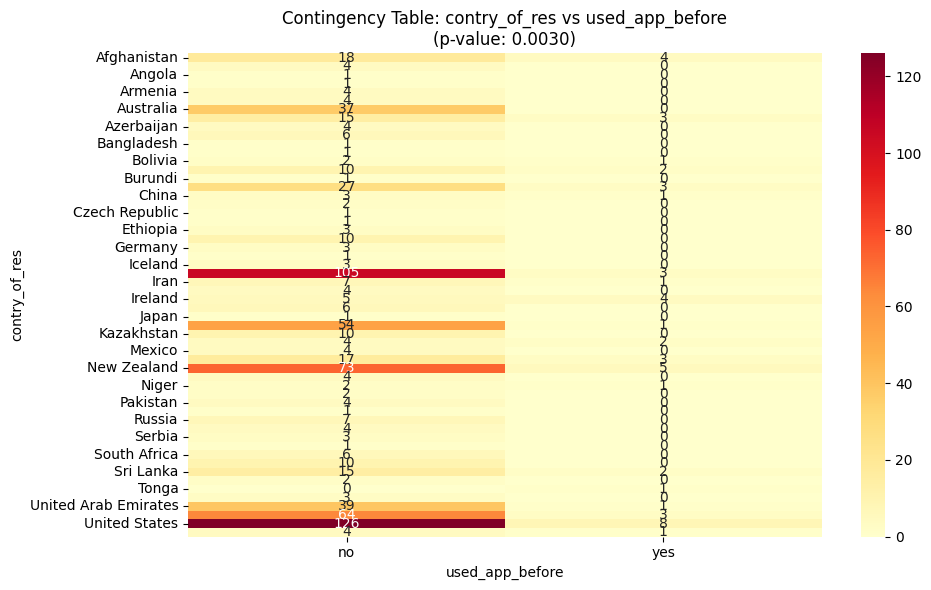

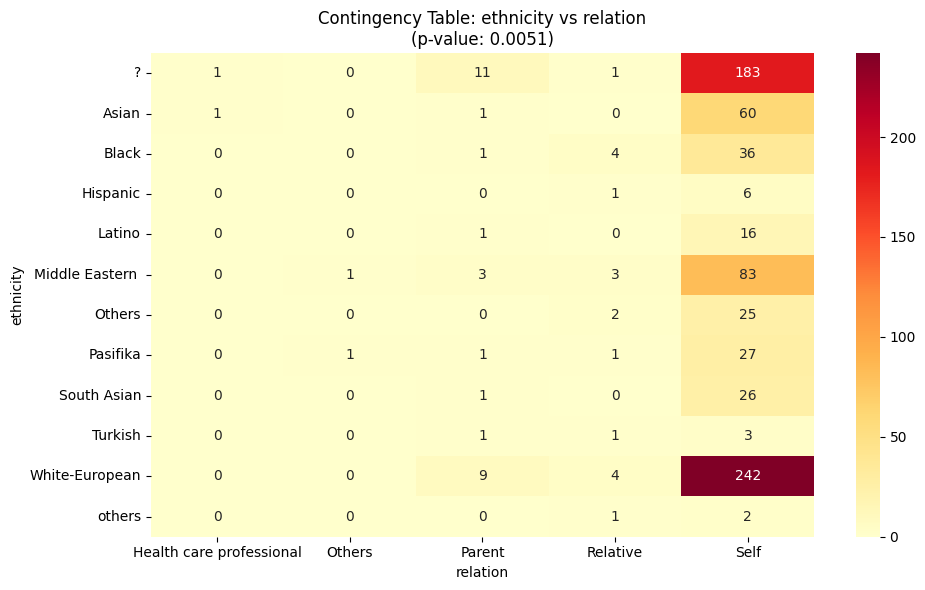

In [88]:
#@title Chi-square (x^2) test of independence
def create_contingency_table(df, var1, var2):
    """Create a contingency table for two categorical variables"""
    return pd.crosstab(df[var1], df[var2])

def perform_chi_square_test(contingency_table):
    """Perform chi-square test of independence"""
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    return {
        'chi2_statistic': chi2,
        'p_value': p_value,
        'degrees_of_freedom': dof
    }

def analyze_categorical_variables(df):
    """Perform chi-square tests on all pairs of categorical variables"""
    categorical_cols = ['gender', 'ethnicity', 'jaundice', 'austim', 
                       'contry_of_res', 'used_app_before', 
                       'relation', 'Class/ASD']
    
    results = []
    
    for i in range(len(categorical_cols)):
        for j in range(i + 1, len(categorical_cols)):
            var1 = categorical_cols[i]
            var2 = categorical_cols[j]
            
            # Create contingency table
            contingency_table = create_contingency_table(df, var1, var2)
            
            # Perform chi-square test
            test_result = perform_chi_square_test(contingency_table)
            
            results.append({
                'variable1': var1,
                'variable2': var2,
                'chi2_statistic': test_result['chi2_statistic'],
                'p_value': test_result['p_value'],
                'degrees_of_freedom': test_result['degrees_of_freedom']
            })
    
    return pd.DataFrame(results)

def plot_significant_relationships(df, results, p_threshold=0.05):
    """Plot contingency tables for significant relationships"""
    significant_results = results[results['p_value'] < p_threshold]
    
    for _, row in significant_results.iterrows():
        var1 = row['variable1']
        var2 = row['variable2']
        
        plt.figure(figsize=(10, 6))
        contingency_table = create_contingency_table(df, var1, var2)
        sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlOrRd')
        plt.title(f'Contingency Table: {var1} vs {var2}\n(p-value: {row["p_value"]:.4f})')
        plt.tight_layout()
        plt.show()
    

results = analyze_categorical_variables(train)

# Sort results by p-value
results = results.sort_values('p_value')

# Print results
print("\nChi-Square Test Results:")
print("========================")
for _, row in results.iterrows():
    print(f"\n{row['variable1']} vs {row['variable2']}:")
    print(f"Chi-square statistic: {row['chi2_statistic']:.2f}")
    print(f"p-value: {row['p_value']:.4f}")
    print(f"Degrees of freedom: {row['degrees_of_freedom']}")

# Plot significant relationships
print("\nPlotting significant relationships (p < 0.05)...")
plot_significant_relationships(train, results)

Mann-Whitney U test results:
U statistic: 59584.00
p-value: 0.0019


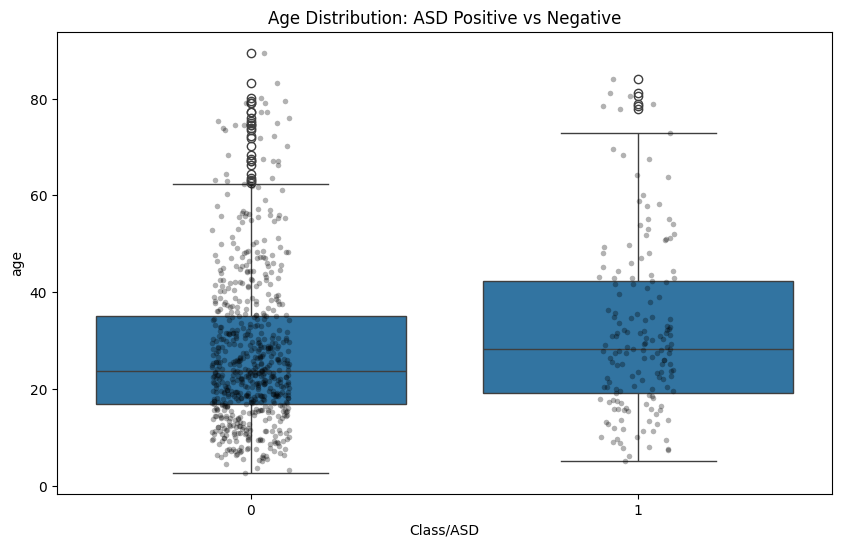

In [89]:
#@title Mann-Whiteney U Test
def perform_mann_whitney_test(data, group_column, value_column, group1, group2):
    """
    Perform Mann-Whitney U test between two groups.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    group_column : str
        Column name containing group labels
    value_column : str
        Column name containing values to compare
    group1 : str/int
        Label of first group
    group2 : str/int
        Label of second group
    
    Returns:
    --------
    tuple
        (U statistic, p-value)
    """
    # Extract values for each group
    group1_values = data[data[group_column] == group1][value_column]
    group2_values = data[data[group_column] == group2][value_column]
    
    # Perform Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(
        group1_values, 
        group2_values, 
        alternative='two-sided'
    )
    
    return statistic, p_value

def plot_group_comparison(data, group_column, value_column, group1, group2, title=None):
    """
    Create a box plot comparing the distribution of values between two groups.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    group_column : str
        Column name containing group labels
    value_column : str
        Column name containing values to compare
    group1 : str/int
        Label of first group
    group2 : str/int
        Label of second group
    title : str, optional
        Plot title
    """
    plt.figure(figsize=(10, 6))
    
    # Create box plot
    sns.boxplot(x=group_column, y=value_column, data=data[data[group_column].isin([group1, group2])])
    
    # Add individual points
    sns.stripplot(x=group_column, y=value_column, data=data[data[group_column].isin([group1, group2])],
                 color='black', alpha=0.3, size=4)
    
    if title:
        plt.title(title)
    plt.show()
    
# Example: Compare age distribution between ASD positive and negative groups
statistic, p_value = perform_mann_whitney_test(
    train, 
    'Class/ASD', 
    'age',
    1,  # ASD positive
    0   # ASD negative
)

print(f"Mann-Whitney U test results:")
print(f"U statistic: {statistic:.2f}")
print(f"p-value: {p_value:.4f}")

# Create visualization
plot_group_comparison(
    train,
    'Class/ASD',
    'age',
    1,
    0,
    title='Age Distribution: ASD Positive vs Negative'
) 

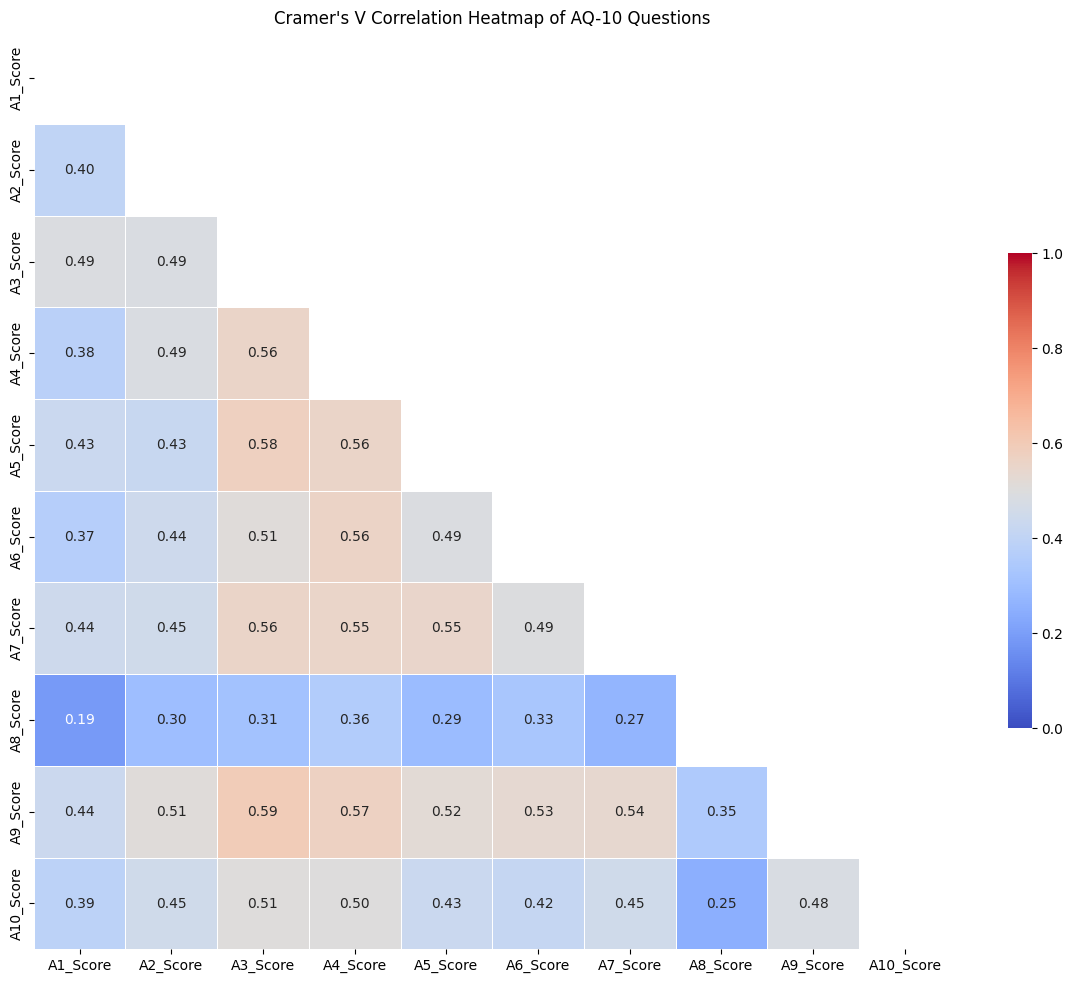


Top 5 strongest correlations between AQ-10 questions:
A3_Score - A9_Score: 0.595
A3_Score - A5_Score: 0.577
A4_Score - A9_Score: 0.574
A4_Score - A6_Score: 0.561
A4_Score - A5_Score: 0.557


In [90]:
#@title Cramér’s V
def cramers_v(confusion_matrix):
    """
    Calculate Cramer's V statistic for categorical-categorical association.
    
    Parameters:
    -----------
    confusion_matrix : numpy.ndarray
        The confusion matrix (contingency table)
    
    Returns:
    --------
    float
        Cramer's V statistic
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    
    return np.sqrt(chi2 / (n * min_dim))

def calculate_cramers_v_matrix(data, columns):
    """
    Calculate Cramer's V for all pairs of categorical variables.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    columns : list
        List of column names to analyze
    
    Returns:
    --------
    pandas.DataFrame
        Matrix of Cramer's V values
    """
    n_cols = len(columns)
    cramers_v_matrix = np.zeros((n_cols, n_cols))
    
    for i in range(n_cols):
        for j in range(n_cols):
            if i == j:
                cramers_v_matrix[i, j] = 1.0
            else:
                confusion_matrix = pd.crosstab(data[columns[i]], data[columns[j]])
                cramers_v_matrix[i, j] = cramers_v(confusion_matrix)
    
    return pd.DataFrame(cramers_v_matrix, index=columns, columns=columns)

def plot_correlation_heatmap(correlation_matrix, title="Cramer's V Correlation Heatmap"):
    """
    Create a heatmap visualization of the correlation matrix.
    
    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        The correlation matrix to visualize
    title : str
        Title for the plot
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                vmin=0,
                vmax=1,
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5})
    
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Get AQ-10 score columns
aq_columns = [col for col in train.columns if col.startswith('A') and col.endswith('_Score')]

# Calculate Cramer's V matrix
cramers_v_matrix = calculate_cramers_v_matrix(train, aq_columns)

# Plot correlation heatmap
plot_correlation_heatmap(
    cramers_v_matrix,
    title="Cramer's V Correlation Heatmap of AQ-10 Questions"
)

# Print some insights
print("\nTop 5 strongest correlations between AQ-10 questions:")
# Get upper triangle of correlation matrix
upper_triangle = cramers_v_matrix.where(np.triu(np.ones(cramers_v_matrix.shape), k=1).astype(bool))
# Stack and sort
correlations = upper_triangle.stack().sort_values(ascending=False)
for (q1, q2), corr in correlations.head().items():
    print(f"{q1} - {q2}: {corr:.3f}") 

## Polychoric Correlation

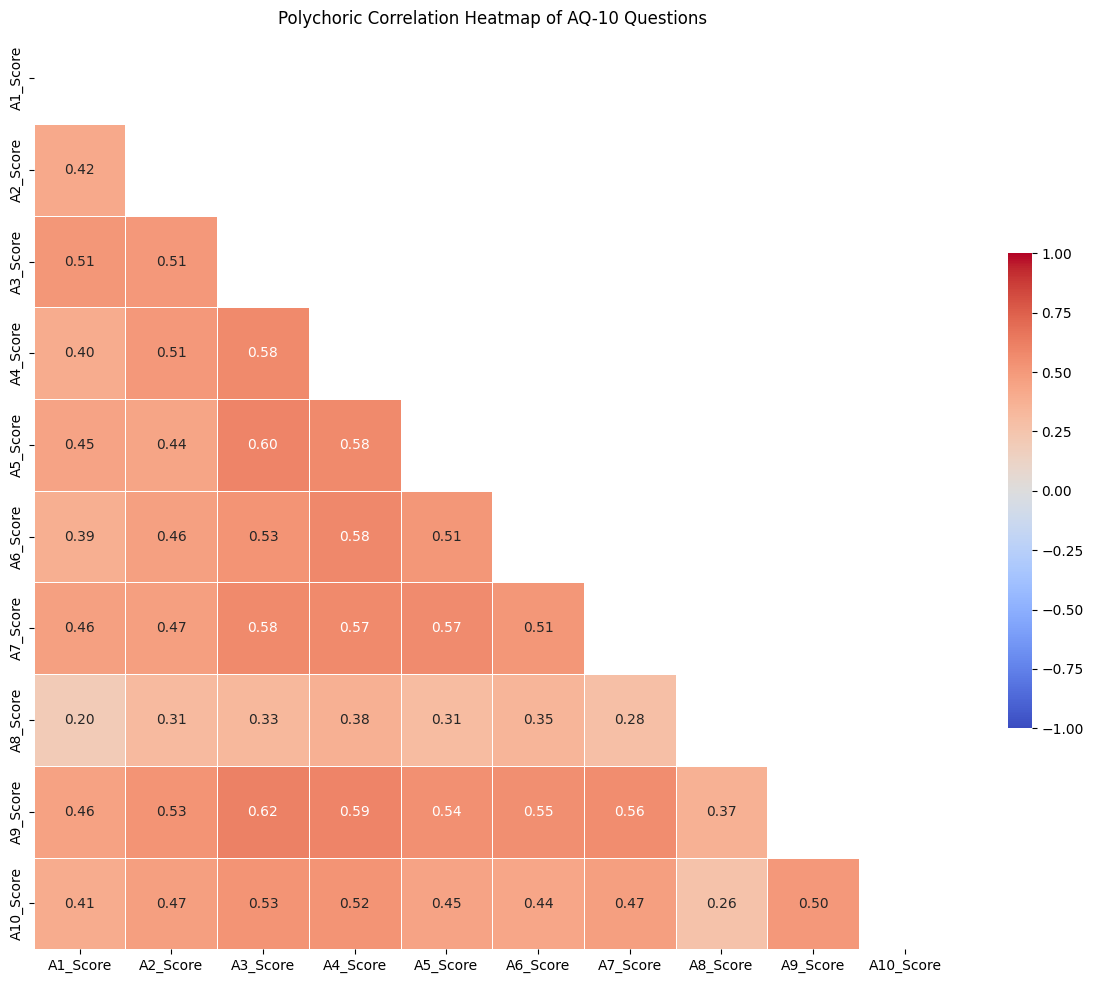


Top 5 strongest correlations between AQ-10 questions:
A3_Score - A9_Score: 0.615
A3_Score - A5_Score: 0.598
A4_Score - A9_Score: 0.595
A4_Score - A6_Score: 0.582
A4_Score - A5_Score: 0.578


In [91]:
#@title Polychoric correlation
def polychoric_approx(x, y):
    """
    Calculate an approximation of polychoric correlation
    using Pearson correlation with a correction factor.
    
    Parameters:
    -----------
    x : pandas.Series
        First ordinal variable
    y : pandas.Series
        Second ordinal variable
        
    Returns:
    --------
    float
        Approximate polychoric correlation coefficient
    """
    # Handle missing values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    # Use Spearman correlation as starting point
    rho_spearman, _ = stats.spearmanr(x_clean, y_clean)
    
    # Apply correction to approximate polychoric correlation
    # This uses a common rule of thumb for converting Spearman to polychoric
    rho_polychoric = 2 * np.sin(np.pi * rho_spearman / 6)
    
    return rho_polychoric

def calculate_polychoric_matrix(data, columns):
    """
    Calculate polychoric correlation for all pairs of ordinal variables.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The input dataframe
    columns : list
        List of column names to analyze
    
    Returns:
    --------
    pandas.DataFrame
        Matrix of polychoric correlation values
    """
    n_cols = len(columns)
    polychoric_matrix = np.zeros((n_cols, n_cols))
    
    for i in range(n_cols):
        for j in range(n_cols):
            if i == j:
                polychoric_matrix[i, j] = 1.0
            else:
                polychoric_matrix[i, j] = polychoric_approx(data[columns[i]], data[columns[j]])
    
    return pd.DataFrame(polychoric_matrix, index=columns, columns=columns)

def plot_polychoric_heatmap(correlation_matrix, title="Polychoric Correlation Heatmap"):
    """
    Create a heatmap visualization of the polychoric correlation matrix.
    
    Parameters:
    -----------
    correlation_matrix : pandas.DataFrame
        The correlation matrix to visualize
    title : str
        Title for the plot
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                vmin=-1,
                vmax=1,
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5})
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage:
# Get AQ-10 score columns
aq_columns = [col for col in train.columns if col.startswith('A') and col.endswith('_Score')]

# Calculate polychoric correlation matrix
polychoric_matrix = calculate_polychoric_matrix(train, aq_columns)

# Plot correlation heatmap
plot_polychoric_heatmap(
    polychoric_matrix, 
    title="Polychoric Correlation Heatmap of AQ-10 Questions"
)

# Print some insights
print("\nTop 5 strongest correlations between AQ-10 questions:")
# Get upper triangle of correlation matrix
upper_triangle = polychoric_matrix.where(np.triu(np.ones(polychoric_matrix.shape), k=1).astype(bool))
# Take absolute values for the strongest correlations (positive or negative)
abs_correlations = upper_triangle.abs().stack().sort_values(ascending=False)
for (q1, q2), corr in abs_correlations.head().items():
    actual_corr = upper_triangle.loc[q1, q2]
    print(f"{q1} - {q2}: {actual_corr:.3f}")

# Phase 2: Supervised Learning Benchmarks

## Logistic Regression + Wald z

Using features: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
Target variable: Class/ASD

Logistic Regression Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5566      0.540    -10.287      0.000      -6.615      -4.498
A1_Score      -0.0541      0.337     -0.161      0.872      -0.715       0.607
A2_Score       0.4246      0.354      1.200      0.230      -0.269       1.118
A3_Score       0.6866      0.388      1.768      0.077      -0.075       1.448
A4_Score       1.0634      0.349      3.048      0.002       0.379       1.747
A5_Score       0.6296      0.321      1.961      0.050       0.000       1.259
A6_Score       1.1557      0.271      4.270      0.000       0.625       1.686
A7_Score       0.4657      0.316      1.475      0.140      -0.153       1.085
A8_Score       

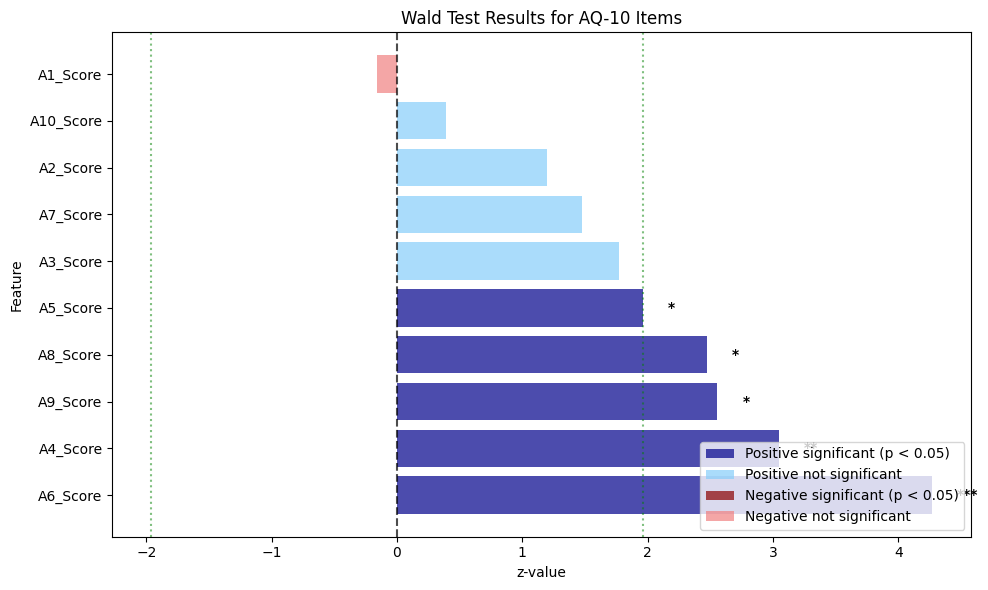


Training Accuracy: 0.8662

Confusion Matrix (Training):
[[582  57]
 [ 50 111]]


In [92]:
#@title Logistic-regression + Wald z tests
def fit_logistic_regression_with_wald(X, y, feature_names=None):
    """
    Fit a logistic regression model and calculate Wald z-tests for each coefficient.
    
    Parameters:
    -----------
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix
    y : pandas.Series or numpy.ndarray
        Target variable (binary)
    feature_names : list, optional
        Names of features (if X is not a DataFrame)
    
    Returns:
    --------
    tuple
        (model, summary_df) - The fitted model and a DataFrame with coefficient statistics
    """
    # If X is a numpy array, convert to DataFrame with feature names
    if not isinstance(X, pd.DataFrame) and feature_names is not None:
        X = pd.DataFrame(X, columns=feature_names)
    elif not isinstance(X, pd.DataFrame):
        feature_names = [f'X{i}' for i in range(X.shape[1])]
        X = pd.DataFrame(X, columns=feature_names)
    
    # Get feature names for later use
    feature_names = X.columns.tolist()
    
    # Add constant term
    X_with_const = sm.add_constant(X)
    
    # Fit logistic regression model
    model = sm.Logit(y, X_with_const)
    result = model.fit(disp=0)  # disp=0 suppresses convergence messages
    
    # Extract coefficient values
    coef = result.params
    
    # Get standard errors
    std_err = result.bse
    
    # Calculate z-values
    z_values = coef / std_err
    
    # Calculate p-values
    p_values = 2 * (1 - stats.norm.cdf(np.abs(z_values)))
    
    # Calculate odds ratios and confidence intervals
    odds_ratios = np.exp(coef)
    conf_int = result.conf_int()
    odds_ratio_ci_lower = np.exp(conf_int[0])
    odds_ratio_ci_upper = np.exp(conf_int[1])
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'Coefficient': coef,
        'Std. Error': std_err,
        'z-value': z_values,
        'p-value': p_values,
        'Odds Ratio': odds_ratios,
        'OR 95% CI Lower': odds_ratio_ci_lower,
        'OR 95% CI Upper': odds_ratio_ci_upper
    })
    
    # Add star notation for significance levels
    summary['Significance'] = ''
    summary.loc[summary['p-value'] < 0.05, 'Significance'] = '*'
    summary.loc[summary['p-value'] < 0.01, 'Significance'] = '**'
    summary.loc[summary['p-value'] < 0.001, 'Significance'] = '***'
    
    return result, summary

def plot_wald_test_results(summary_df, title="Wald Test Results"):
    """
    Create a visualization of Wald test results.
    
    Parameters:
    -----------
    summary_df : pandas.DataFrame
        Summary DataFrame from fit_logistic_regression_with_wald function
    title : str
        Title for the plot
    """
    # Drop the constant for plotting
    plot_df = summary_df.drop('const', errors='ignore').copy()
    
    # Sort by absolute z-value
    plot_df = plot_df.iloc[np.argsort(np.abs(plot_df['z-value']))[::-1]]
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, max(6, len(plot_df) * 0.5)))
    
    # Create horizontal barplot of z-values
    bars = ax.barh(
        y=plot_df.index,
        width=plot_df['z-value'],
        color=[
            'darkred' if z < 0 and p < 0.05 else
            'darkblue' if z > 0 and p < 0.05 else
            'lightcoral' if z < 0 else 'lightskyblue'
            for z, p in zip(plot_df['z-value'], plot_df['p-value'])
        ],
        alpha=0.7
    )
    
    # Add significance markers
    for i, (idx, row) in enumerate(plot_df.iterrows()):
        if row['Significance']:
            ax.text(
                x=row['z-value'] + (0.2 if row['z-value'] >= 0 else -0.6), 
                y=i,
                s=row['Significance'],
                ha='left' if row['z-value'] >= 0 else 'right',
                va='center',
                fontweight='bold'
            )
    
    # Add reference line at z=0
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Add reference lines for significance thresholds
    ax.axvline(x=1.96, color='green', linestyle=':', alpha=0.5)  # p < 0.05
    ax.axvline(x=-1.96, color='green', linestyle=':', alpha=0.5)  # p < 0.05
    
    # Customize plot
    ax.set_title(title)
    ax.set_xlabel('z-value')
    ax.set_ylabel('Feature')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='darkblue', alpha=0.7, label='Positive significant (p < 0.05)'),
        Patch(facecolor='lightskyblue', alpha=0.7, label='Positive not significant'),
        Patch(facecolor='darkred', alpha=0.7, label='Negative significant (p < 0.05)'),
        Patch(facecolor='lightcoral', alpha=0.7, label='Negative not significant')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()

def analyze_aq_logistic_regression(train, test=None):
    """
    Perform logistic regression analysis on the AQ-10 data.
    
    Parameters:
    -----------
    train : pandas.DataFrame
        Training data with AQ-10 scores and target variable
    test : pandas.DataFrame, optional
        Test data for evaluation
    
    Returns:
    --------
    tuple
        (model, summary_df, confusion_matrix) - Fitted model, summary statistics, and confusion matrix
    """
    # Get AQ-10 score columns
    aq_columns = [col for col in train.columns if col.startswith('A') and col.endswith('_Score')]
    
    # Assume the target variable is 'Class/ASD' or similar
    target_columns = [col for col in train.columns if 'ASD' in col or 'Class' in col or 'Target' in col]
    
    if not target_columns:
        raise ValueError("Could not find target column. Please specify the target column name.")
    
    target_column = target_columns[0]
    
    print(f"Using features: {aq_columns}")
    print(f"Target variable: {target_column}")
    
    # Extract features and target
    X_train = train[aq_columns]
    y_train = train[target_column]
    
    # Fit logistic regression and get Wald tests
    model, summary = fit_logistic_regression_with_wald(X_train, y_train)
    
    # Print model summary
    print("\nLogistic Regression Summary:")
    print(model.summary().tables[1])
    
    # Print Wald test summary
    print("\nWald Test Results:")
    print(summary)
    
    # Plot Wald test results
    plot_wald_test_results(summary, title="Wald Test Results for AQ-10 Items")
    
    # Check model performance on training data
    y_train_pred = model.predict(sm.add_constant(X_train)) > 0.5
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    
    print(f"\nTraining Accuracy: {train_accuracy:.4f}")
    print("\nConfusion Matrix (Training):")
    print(train_conf_matrix)
    
    # Evaluate on test data if provided
    if test is not None:
        X_test = test[aq_columns]
        y_test = test[target_column]
        
        y_test_pred = model.predict(sm.add_constant(X_test)) > 0.5
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_conf_matrix = confusion_matrix(y_test, y_test_pred)
        
        print(f"\nTest Accuracy: {test_accuracy:.4f}")
        print("\nConfusion Matrix (Test):")
        print(test_conf_matrix)
        
        # Calculate and plot ROC curve
        y_test_prob = model.predict(sm.add_constant(X_test))
        fpr, tpr, _ = roc_curve(y_test, y_test_prob)
        roc_auc = roc_auc_score(y_test, y_test_prob)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.show()
        
        # Plot feature importance based on absolute z-values
        feature_importance = summary.loc[aq_columns, ['z-value']].abs().sort_values('z-value', ascending=False)
        
        plt.figure(figsize=(10, 6))
        feature_importance['z-value'].plot(kind='bar', color='lightblue', alpha=0.7)
        plt.title('Feature Importance (Absolute z-values)')
        plt.xlabel('AQ-10 Item')
        plt.ylabel('|z-value|')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Return test confusion matrix
        return model, summary, test_conf_matrix
    
    # If no test data, return training confusion matrix
    return model, summary, train_conf_matrix

# Execute the analysis
model, summary, conf_matrix = analyze_aq_logistic_regression(train)

# If you have a separate test set:
# model, summary, conf_matrix = analyze_aq_logistic_regression(train, test)

## Random Forest Prediction

Using features: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
Target variable: Class/ASD


C:\Users\33322\AppData\Local\Temp\ipykernel_25100\4221537253.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df,


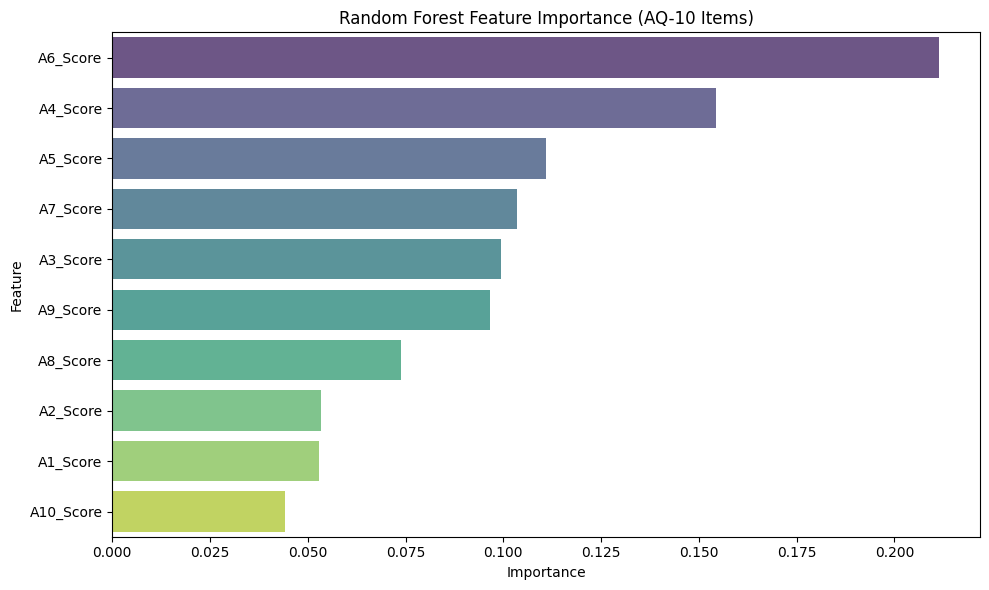


Top 5 most important features:
    Feature  Importance
0  A6_Score    0.211318
1  A4_Score    0.154339
2  A5_Score    0.110814
3  A7_Score    0.103441
4  A3_Score    0.099277
Cross-Validation Results (5 folds):
Accuracy: 0.8450 ± 0.0150
Precision: 0.6238 ± 0.0470
Recall: 0.6023 ± 0.0474
F1: 0.6100 ± 0.0245
Roc_auc: 0.8873 ± 0.0128


C:\Users\33322\AppData\Local\Temp\ipykernel_25100\4221537253.py:195: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=perm_importance_df,


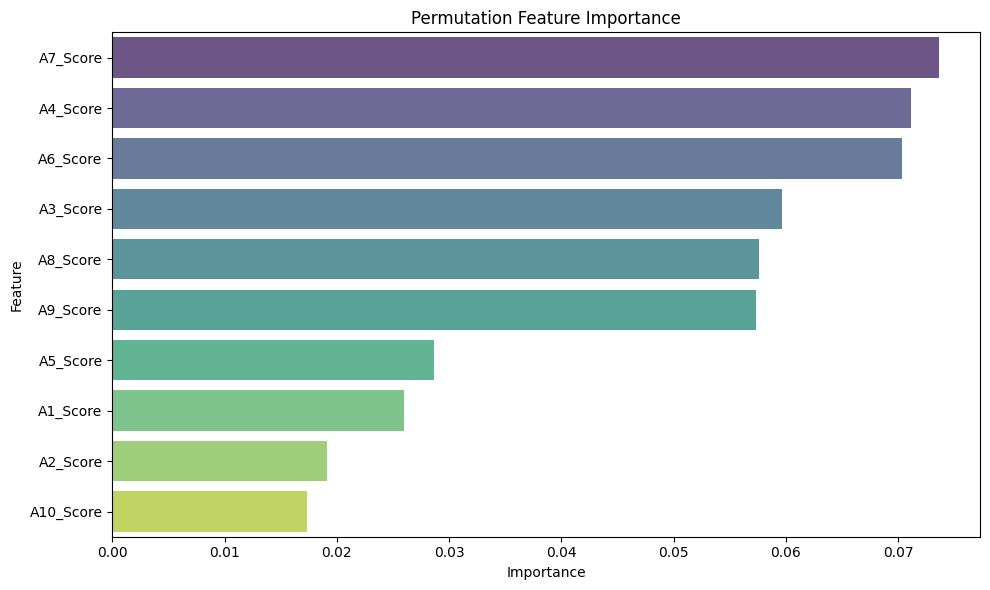


Training Accuracy: 0.9075

Confusion Matrix (Training):
[[603  36]
 [ 38 123]]


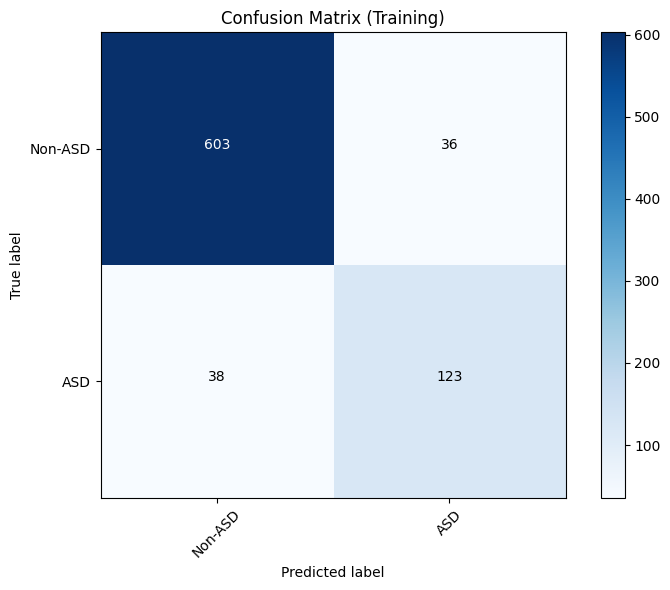

In [93]:
# Identify categorical and numerical columns
def fit_random_forest(X, y, n_estimators=100, max_depth=None, random_state=42):
    """
    Fit a Random Forest classifier.
    
    Parameters:
    -----------
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix
    y : pandas.Series or numpy.ndarray
        Target variable (binary)
    n_estimators : int, optional
        Number of trees in the forest
    max_depth : int or None, optional
        Maximum depth of trees
    random_state : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    RandomForestClassifier
        Fitted Random Forest model
    """
    # Create and fit the model
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1  # Use all available cores
    )
    rf.fit(X, y)
    
    return rf

def plot_feature_importance(model, feature_names, title="Random Forest Feature Importance"):
    """
    Plot feature importance from a fitted Random Forest model.
    
    Parameters:
    -----------
    model : RandomForestClassifier
        Fitted Random Forest model
    feature_names : list
        Names of features
    title : str
        Plot title
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices],
        'Importance': importances[indices]
    })
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, 
                palette='viridis', alpha=0.8)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    return importance_df

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot confusion matrix with nice formatting.
    
    Parameters:
    -----------
    cm : numpy.ndarray
        Confusion matrix
    classes : list
        List of class names
    normalize : bool, optional
        Whether to normalize the confusion matrix
    title : str, optional
        Plot title
    cmap : matplotlib.colors.Colormap, optional
        Color map for the plot
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def perform_cross_validation(model, X, y, cv=5):
    """
    Perform cross-validation and return scores.
    
    Parameters:
    -----------
    model : scikit-learn model
        Model to cross-validate
    X : pandas.DataFrame
        Feature data
    y : pandas.Series
        Target variable
    cv : int, optional
        Number of cross-validation folds
    
    Returns:
    --------
    dict
        Dictionary with cross-validation results
    """
    # Create stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Calculate cross-validated scores
    cv_accuracy = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    cv_precision = cross_val_score(model, X, y, cv=skf, scoring='precision')
    cv_recall = cross_val_score(model, X, y, cv=skf, scoring='recall')
    cv_f1 = cross_val_score(model, X, y, cv=skf, scoring='f1')
    cv_roc_auc = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    
    # Compile results
    cv_results = {
        'accuracy': cv_accuracy,
        'precision': cv_precision,
        'recall': cv_recall,
        'f1': cv_f1,
        'roc_auc': cv_roc_auc
    }
    
    # Print CV results
    print(f"Cross-Validation Results ({cv} folds):")
    for metric, values in cv_results.items():
        print(f"{metric.capitalize()}: {values.mean():.4f} ± {values.std():.4f}")
    
    return cv_results

def compute_permutation_importance(model, X, y, n_repeats=10, random_state=42):
    """
    Calculate permutation feature importance.
    
    Parameters:
    -----------
    model : fitted scikit-learn model
        Model to evaluate
    X : pandas.DataFrame
        Feature data
    y : pandas.Series
        Target variable
    n_repeats : int, optional
        Number of times to permute each feature
    random_state : int, optional
        Random seed
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with permutation importance results
    """
    # Calculate permutation importance
    perm_importance = permutation_importance(
        model, X, y, n_repeats=n_repeats, random_state=random_state, n_jobs=-1
    )
    
    # Create DataFrame
    perm_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean,
        'Std': perm_importance.importances_std
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df, 
                palette='viridis', alpha=0.8)
    plt.title('Permutation Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return perm_importance_df

def analyze_random_forest(train, test=None, n_estimators=100, max_depth=None):
    """
    Perform Random Forest analysis on the AQ-10 data.
    
    Parameters:
    -----------
    train : pandas.DataFrame
        Training data with AQ-10 scores and target variable
    test : pandas.DataFrame, optional
        Test data for evaluation
    n_estimators : int, optional
        Number of trees in the forest
    max_depth : int or None, optional
        Maximum depth of trees
    
    Returns:
    --------
    tuple
        (model, importance_df) - Fitted model and feature importance DataFrame
    """
    # Get AQ-10 score columns
    aq_columns = [col for col in train.columns if col.startswith('A') and col.endswith('_Score')]
    
    # Assume the target variable is 'Class/ASD' or similar
    target_columns = [col for col in train.columns if 'ASD' in col or 'Class' in col or 'Target' in col]
    
    if not target_columns:
        raise ValueError("Could not find target column. Please specify the target column name.")
    
    target_column = target_columns[0]
    
    print(f"Using features: {aq_columns}")
    print(f"Target variable: {target_column}")
    
    # Extract features and target
    X_train = train[aq_columns]
    y_train = train[target_column]
    
    # Fit Random Forest
    rf_model = fit_random_forest(X_train, y_train, n_estimators=n_estimators, max_depth=max_depth)
    
    # Plot feature importance
    importance_df = plot_feature_importance(rf_model, X_train.columns, 
                                          title="Random Forest Feature Importance (AQ-10 Items)")
    
    # Print top features
    print("\nTop 5 most important features:")
    print(importance_df.head(5))
    
    # Perform cross-validation
    cv_results = perform_cross_validation(rf_model, X_train, y_train, cv=5)
    
    # Calculate permutation importance
    perm_importance = compute_permutation_importance(rf_model, X_train, y_train)
    
    # Print model performance on training data
    y_train_pred = rf_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    
    print(f"\nTraining Accuracy: {train_accuracy:.4f}")
    print("\nConfusion Matrix (Training):")
    print(train_conf_matrix)
    
    # Plot confusion matrix
    class_names = ['Non-ASD', 'ASD'] if len(np.unique(y_train)) <= 2 else [str(i) for i in range(len(np.unique(y_train)))]
    plot_confusion_matrix(train_conf_matrix, classes=class_names, 
                         title='Confusion Matrix (Training)')
    
    # Evaluate on test data if provided
    if test is not None:
        X_test = test[aq_columns]
        y_test = test[target_column]
        
        y_test_pred = rf_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_conf_matrix = confusion_matrix(y_test, y_test_pred)
        
        print(f"\nTest Accuracy: {test_accuracy:.4f}")
        print("\nConfusion Matrix (Test):")
        print(test_conf_matrix)
        
        # Plot test confusion matrix
        plot_confusion_matrix(test_conf_matrix, classes=class_names, 
                             title='Confusion Matrix (Test)')
        
        # Calculate and plot ROC curve
        if len(np.unique(y_test)) == 2:  # Binary classification
            y_test_prob = rf_model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_test_prob)
            roc_auc = roc_auc_score(y_test, y_test_prob)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc='lower right')
            plt.grid(alpha=0.3)
            plt.show()
        
        return rf_model, importance_df, test_conf_matrix, cv_results
    
    return rf_model, importance_df, train_conf_matrix, cv_results

# Execute the analysis
rf_model, importance_df, conf_matrix, cv_results = analyze_random_forest(train, n_estimators=100)

# If you have a separate test set:
# rf_model, importance_df, conf_matrix, cv_results = analyze_random_forest(train, test, n_estimators=100)